In [24]:
# ============================================================================
# STEP 1 — Imports & global setup
# ============================================================================

# Stdlib
from pathlib import Path
import warnings
import logging

# Core numerics & data
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
from matplotlib import animation           # for GIF/MP4 lap animations
from matplotlib.gridspec import GridSpec   # flexible subplot layout

# SciPy utilities
from scipy import interpolate, optimize
from scipy.signal import savgol_filter

# FastF1 (timing, telemetry, weather, etc.)
import fastf1
import collector, importlib
# --- Tidy the console output ---
# Hide noisy warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Quiet FastF1 logs (keep only errors)
# fastf1.set_log_level(logging.ERROR)
fastf1.set_log_level(logging.INFO) 

# --- FastF1 on-disk cache (highly recommended) ---
# Why a cache?
#   - Speeds up reruns dramatically: session data is downloaded once, then reused.
#   - Reduces network dependency and rate-limit hits; we can work offline once cached.
#   - Improves reproducibility: we use the same raw timing/telemetry snapshot across runs.
# What it stores: timing, telemetry, weather, track status per session.
cache_dir = "f1_cache"
Path(cache_dir).mkdir(parents=True, exist_ok=True)

# API name differs across FastF1 versions — try both for compatibility
try:
    fastf1.Cache.enable_cache(cache_dir)   # newer API
except AttributeError:
    try:
        fastf1.Cache.enable(cache_dir)     # older API
    except Exception as e:
        print(f"⚠️ Could not enable FastF1 cache at '{cache_dir}': {e}")
            

In [25]:
# ============================================================================
# Utility — integrate simulated time on the real telemetry distance grid
# ============================================================================

def sim_time_from_real_grid(segments_df: pd.DataFrame, telemetry: pd.DataFrame):
    """
    Interpolate the simulated segment speeds onto the real telemetry distance
    samples and integrate dt = ds / v to obtain cumulative time.

    Args:
        segments_df: DataFrame with columns ['start','end','optimized_speed'].
        telemetry:   DataFrame with columns ['Distance','Speed', ...].

    Returns:
        dist (np.ndarray): telemetry distance samples used (m)
        sim_speed_on_real (np.ndarray): simulated speed at those samples (km/h)
        cum_time (np.ndarray): cumulative simulated time (s)
    """
    # Real distance samples (sorted, de-duplicated)
    tel = telemetry.sort_values('Distance').reset_index(drop=True)
    dist = tel['Distance'].to_numpy(float)

    # Restrict to overlap with segment coverage to avoid extrapolation
    s_max = float(min(dist[-1], segments_df['end'].max()))
    dist = dist[dist <= s_max]

    # Enforce non-decreasing distances and drop zero-steps (GPS jitter guard)
    dist = np.maximum.accumulate(dist)
    step_mask = np.r_[True, np.diff(dist) > 1e-9]
    dist = dist[step_mask]

    # Simulated speeds at segment midpoints
    seg_mid = 0.5 * (segments_df['start'].to_numpy(float) + segments_df['end'].to_numpy(float))
    sim_speed = segments_df['optimized_speed'].to_numpy(float)

    # Guard: make x monotonic & unique for interpolation
    order = np.argsort(seg_mid)
    seg_mid = seg_mid[order]
    sim_speed = sim_speed[order]
    seg_mid, uniq_idx = np.unique(seg_mid, return_index=True)
    sim_speed = sim_speed[uniq_idx]

    # Interpolate sim speeds to the real distance grid and integrate time
    sim_speed_on_real = np.interp(dist, seg_mid, sim_speed)
    v_mps = np.clip(sim_speed_on_real / 3.6, 1e-3, None)

    ds = np.diff(dist, prepend=dist[0])   # first step = 0
    dt = ds / v_mps
    cum_time = np.cumsum(dt)

    return dist, sim_speed_on_real, cum_time


<details>
<summary><span style="color:red">Derived Lateral g Explained 👇</span></summary>

**Lateral g** is the sideways acceleration experienced in a corner, measured as a multiple of gravitational acceleration ($g \approx 9.81\ \text{m/s}^2$).

**Lateral g Calculation**  

Instead of reading from an accelerometer, we compute it from speed and path curvature. For planar motion, centripetal acceleration is:

$$
a_\text{lat} = v^2 \, \kappa
$$

where $v$ is speed in m/s and $\kappa$ is path curvature in $1/m$.

To convert acceleration to “g” units:

$$
\text{lateral\_g} = \frac{v^2\,\kappa}{g}
$$

with $g = 9.81\,\text{m/s}^2$.

**Code Mapping**  

In STEP 2 → `get_fastest_lap_telemetry()`:
- Curvature is computed from heading change vs. distance:
```python
theta = np.unwrap(np.arctan2(dy, dx)) # heading θ(s)
kappa = np.abs(np.gradient(theta, s)) # κ(s) = |dθ/ds| [1/m]
```
- $dx/ds$, $dy/ds$ come from lightly smoothed $x(s)$, $y(s)$ (Savitzky–Golay) to suppress GPS jitter.
- np.abs(...) means we store the magnitude of curvature (no left/right sign).  


We convert Speed from km/h → m/s, then compute lateral g:  
- Speed is converted from km/h → m/s, then lateral g is calculated:
```python
v_mps = tel["Speed"].to_numpy(float) / 3.6
self.telemetry["lat_g"] = (v_mps * v_mps * kappa) / 9.81
```

This matches $v^2\,\kappa/g$ exactly.

**Notes & Options**  

- **Units:** $v$ in m/s, $\kappa$ in 1/m.
- **Smoothing:** Savitzky–Golay smoothing of $x, y$ is crucial; unsmoothed GPS produces spiky $\kappa$ and unrealistic lateral-g.
- **Clipping:** $\kappa$ is clipped at ≤ 0.3 1/m (min radius ≈ 3 m) to remove spikes.
- **Sign (optional):** For signed lateral-g, drop the absolute value:

    ```python
    kappa_signed = np.gradient(theta, s)  # remove abs
    lat_g_signed = (v_mps * v_mps * kappa_signed) / 9.81
    ```
- **Missing data:** If $x, y$ are missing, fallback is zeros for curvature and lateral-g, avoiding downstream errors.
/<details>


<details>
<summary><span style="color:red">More details about method <code>get_fastest_lap_telemetry</code>👇</span></summary>  

#### **🔹 What does “merge car data and position via nearest-time asof with a safe tolerance” mean?**  

Merging: In data processing, merging means combining two tables (DataFrames) into one by matching rows on some common key.
Example: one table has speed vs. time, another has position vs. time → we want a single table with speed and position aligned row-by-row.

**Nearest-time asof:**  

In pandas, `merge_asof` is a special merge that matches rows by the nearest key rather than requiring exact equality.  
Here, the key is time (either "Time" or "SessionTime").
Because telemetry and GPS position may be recorded at slightly different timestamps (e.g., car data at 10 Hz and GPS at 5 Hz), we match each car-data row to the closest position sample.  
“asof” means “as of this time, give me the nearest available sample.”  

**Scenario**  

We have car telemetry (speed) recorded every 0.1 s.  
We have GPS position recorded every 0.2 s.  
They don’t line up exactly — so if we just did a normal merge on Time, we’d get almost nothing.

**Data tables**  

**Car telemetry (Speed vs Time):**

| Time | Speed |
|-------|-------|
| 0.0   | 100   |
| 0.1   | 105   |
| 0.2   | 108   |
| 0.3   | 110   |
| 0.4   | 109   |

**GPS position (X,Y vs Time):**

| Time | X   | Y   |
|-------|-----|-----|
| 0.0   | 0.0 | 0.0 |
| 0.2   | 2.0 | 1.0 |
| 0.4   | 4.0 | 0.0 |


**What happens if we do a normal merge?**   
```python
pd.merge(car, gps, on="Time")
```

We only get rows where Time matches exactly.  
That would be just at 0.0, 0.2, 0.4 → we lose most telemetry.


**What happens with `merge_asof` (nearest-time)?**    

```python
pd.merge_asof(car, gps, on="Time", direction="nearest", tolerance=pd.Timedelta("150ms"))
```
This matches each car row with the closest GPS row, within ±0.15 s.  
Result:

| Time | Speed | X   | Y   |
|-------|-------|-----|-----|
| 0.0   | 100   | 0.0 | 0.0 |     (exact match)  
| 0.1   | 105   | 0.0 | 0.0 |     (nearest to 0.0)  
| 0.2   | 108   | 2.0 | 1.0 |     (exact match)  
| 0.3   | 110   | 2.0 | 1.0 |     (nearest to 0.2)  
| 0.4   | 109   | 4.0 | 0.0 |     (exact match)  

👉 Now every telemetry row has an X,Y position attached.  
The tolerance (150 ms) makes sure we don’t match if the nearest GPS sample is too far away.  
For example, if telemetry at 0.9 s looked for GPS but the closest sample was at 0.4 s, that’s a 0.5 s gap > tolerance, so it would stay NaN.

```python
import pandas as pd

# ---------------------------
# Sample data (from the example)
# ---------------------------
car = pd.DataFrame({
    "Time":  [0.0, 0.1, 0.2, 0.3, 0.4],   # seconds
    "Speed": [100, 105, 108, 110, 109],   # km/h (example)
})

gps = pd.DataFrame({
    "Time": [0.0, 0.2, 0.4],              # seconds (lower rate)
    "X":    [0.0, 2.0, 4.0],
    "Y":    [0.0, 1.0, 0.0],
})

# Ensure both are sorted by the merge key (required by merge_asof)
car = car.sort_values("Time").reset_index(drop=True)
gps = gps.sort_values("Time").reset_index(drop=True)

print("Car telemetry:\n", car, "\n")
print("GPS position:\n", gps, "\n")

# ---------------------------
# 1) Normal merge (exact matches only)
# ---------------------------
exact = pd.merge(car, gps, on="Time")
print("Exact merge (pd.merge on Time):\n", exact, "\n")

# ---------------------------
# 2) Nearest-time asof merge with a safe tolerance (±0.15 s)
# ---------------------------
nearest_015 = pd.merge_asof(
    car, gps,
    on="Time",
    direction="nearest",
    tolerance=0.15  # seconds, since 'Time' is numeric (floats)
)
print("Nearest-time asof (tolerance = 0.15 s):\n", nearest_015, "\n")

# For reference, show which GPS row each car row matched to
# (index of the GPS row via merge_asof with 'suffixes')
nearest_015_idx = pd.merge_asof(
    car.assign(gps_idx=-1), gps.reset_index().rename(columns={"index": "gps_idx"}),
    on="Time", direction="nearest", tolerance=0.15
)
# print("Which GPS index was used (tolerance = 0.15 s):\n", nearest_015_idx[["Time","gps_idx"]], "\n")

# ---------------------------
# 3) If tolerance is too small, some rows will not match (become NaN)
# ---------------------------
nearest_005 = pd.merge_asof(
    car, gps,
    on="Time",
    direction="nearest",
    tolerance=0.05  # too tight for the 0.1 ↔ 0.0 / 0.2 spacing
)
print("Nearest-time asof (tolerance = 0.05 s):\n", nearest_005, "\n")
```

**Why this matters in our lap simulator**  

Telemetry (Speed/Throttle/Brake) and Position (X,Y) often have different sample rates.  
We want one combined table where each speed sample knows its position on track.  
`merge_asof` is the right tool: it says “for each telemetry timestamp, give me the nearest GPS timestamp, as long as it’s close enough.”

**Safe tolerance:**  

We don’t want to match data that are too far apart in time (e.g., speed from 10 s and GPS from 10.5 s are probably not “the same moment”).
So we specify a tolerance (here 300 ms). If no GPS sample is within ±300 ms of a car-data sample, we leave it empty (NaN) instead of forcing a bad match.

👉 Why we need this: To get one table where every row has both car telemetry (speed, throttle, brake…) and GPS coordinates (X, Y, Z), so later steps like curvature calculation are possible.


#### **🔹 What does “fallback to ISA” mean?**  

ISA = International Standard Atmosphere — a standard model of air at sea level:
- Pressure = 1013.25 hPa,
- Temperature = 15 °C,
- Air density = 1.225 kg/m³.

**In the code:**  

If the session’s weather data is available, we compute air density ρ from actual air temp & pressure.
If not, we fallback = use the ISA default value (ρ = 1.225).
This guarantees that aerodynamic formulas (drag, downforce) still work even if weather data is missing.

👉 Why we need this: Drag and downforce depend on ρ; without it, physics would break. ISA provides a reasonable default.


#### **🔹 What does “Savitzky–Golay smoothing” mean?**  

A Savitzky–Golay filter is a method for smoothing noisy data while preserving important features like peaks and slopes.
It works by sliding a small window across the data and fitting a low-order polynomial (like quadratic) inside each window, then replacing the central point with the fitted value.

**In our code:**  
```python
xs = savgol_filter(x, w, 2, mode="interp")
ys = savgol_filter(y, w, 2, mode="interp")
``` 

Smooth the X and Y GPS coordinates with a polynomial of order 2. 
Window size w ≈ 1% of the lap samples.
This suppresses GPS jitter, which would otherwise make curvature (based on derivatives of x and y) very spiky and unrealistic.

👉 Why we need this: To get stable derivatives (dx/ds, dy/ds, dθ/ds) and thus realistic curvature and lateral-g, instead of huge spikes from noisy GPS.


✅ **In short:**  

- Merge via nearest-time asof = align telemetry and GPS that are recorded at different rates, within a safe time tolerance.
- Fallback to ISA = if weather isn’t available, assume standard air density (1.225 kg/m³).
- Savitzky–Golay smoothing = a smoothing filter that keeps curve shape but reduces noise in XY, so curvature/lateral-g calculations are stable.

<details>


<details>
<summary><span style="color:red">More details about method <code>.add_distance()</code>👇</span></summary>  

**1) `.add_distance()`**  

In FastF1, when we call:
```python
car = fastest_lap.get_car_data()
``` 

we get a `CarData` DataFrame with things like:

| Time                  | Speed | Throttle | Brake | nGear |
|-----------------------|-------|----------|-------|-------|
| 0 days 00:00:00.000   | 100   | 80       | 0     | 4     |
| 0 days 00:00:00.100   | 105   | 90       | 0     | 4     |
| 0 days 00:00:00.200   | 110   | 100      | 0     | 5     |
| ...                   | ...   | ...      | ...   | ...   |


Notice the index: it’s **Time**, not a numeric column.  
It has no **Distance** column yet.

When we do:  
```python
car = car.add_distance()
``` 

FastF1 integrates the speed over time to estimate how far the car has traveled since the start of the lap, and adds a new column **Distance**:

| Time                  | Speed | Throttle | Brake | nGear | Distance |
|-----------------------|-------|----------|-------|-------|----------|
| 0 days 00:00:00.000   | 100   | 80       | 0     | 4     | 0.0      |
| 0 days 00:00:00.100   | 105   | 90       | 0     | 4     | 10.3     |
| 0 days 00:00:00.200   | 110   | 100      | 0     | 5     | 20.8     |
| ...                   | ...   | ...      | ...   | ...   | ...      |

Distances are in meters.  
This way we can plot Speed vs Distance or align telemetry with track position.  
Without `.add_distance()`, we’d only have Speed vs Time.  

👉 **In short:** `.add_distance()` adds a cumulative distance travelled along the lap.


**2) `.reset_index()`**  


After `.add_distance()`, the DataFrame still has **Time** as its index (the left-hand labels).  
That’s inconvenient for merging, because we usually want Time as a normal column.  
Example:

Before `reset_index()`:

| Index (Time)           | Speed | Throttle | Distance |
|------------------------|-------|----------|----------|
| 0 days 00:00:00.000    | 100   | 80       | 0.0      |
| 0 days 00:00:00.100    | 105   | 90       | 10.3     |
| ...                    | ...   | ...      | ...      |

After `reset_index()`:

|   | Time                 | Speed | Throttle | Distance |
|---|----------------------|-------|----------|----------|
| 0 | 0 days 00:00:00.000  | 100   | 80       | 0.0      |
| 1 | 0 days 00:00:00.100  | 105   | 90       | 10.3     |
| ... | ...                 | ...   | ...      | ...      |

Now **Time** is a proper column instead of an index.  
This makes it easy to do things like `pd.merge_asof(car, pos, on="Time", ...)`.

👉 **In short:** `reset_index()` turns the DataFrame’s index (here Time) into a regular column so we can merge/join with other tables that also have a Time column.


**✅ So putting it together:**  
```python
car = fastest_lap.get_car_data().add_distance().reset_index()
```

means:  
- Get car telemetry.  
- Compute & add the Distance column (in meters).  
- Flatten the table so Time is a column, not an index → ready to merge with position data.
</details>

In [26]:
# ============================================================================
# STEP 2 — Circuit data (session load, telemetry merge, curvature)
# ============================================================================

class CircuitData:
    # It's a helper class responsible for getting a session, extracting its fastest lap, merging car telemetry with GPS positions, computing air density, and deriving curvature and lateral‑g.
    """
    Load a FastF1 session and prepare a clean telemetry table for the fastest lap:
      • car channels aligned to distance 
            “car channels” refers to the different streams of telemetry data recorded from a Formula 1 car’s sensors.
            Each channel represents one type of measurement — for example:
            Speed (km/h)
            Throttle (percentage pressed)
            Brake pressure
            Steering angle
            Gear
            RPM
            DRS status
            So when we says “car channels aligned to distance”, it means all these telemetry signals are resampled or synchronized so that they line up consistently along the car’s distance traveled around the track (instead of being slightly off due to different sampling rates or timings).
      • XY position merged (with interpolation/ffill/bfill)
            XY position → the car’s position on the track, given by its X (horizontal) and Y (vertical) coordinates.
            merged → these X and Y values are combined into a single, consistent dataset/table.
            with interpolation / ffill / bfill → sometimes the raw data has gaps or mismatched samples (for example, an X value without a corresponding Y at that exact moment). To fix this:
            interpolation fills in missing values by estimating between known points (e.g., linearly between two positions).
            ffill (forward fill) copies the last known value forward until a new one appears.
            bfill (backward fill) copies the next known value backward to fill earlier gaps.
            In short: it means we cleaned and synchronized the X and Y track position data so it’s continuous and aligned, with no missing entries.
      • air density from weather
      • curvature κ from heading change (stable vs. raw second derivatives)
            1. Curvature κ: In math/physics, curvature (κ) measures how sharply a curve bends at a point. On a racetrack, it tells us how tight the car is turning at each position.
            2. from heading change: Heading = the direction the car is pointing (its angle relative to some axis). Instead of calculating curvature directly from noisy position data (x,y), we can compute it from the rate of change of heading with respect to distance traveled. This method is usually more stable.
            3. (stable vs. raw second derivatives): A traditional way to compute curvature is by taking second derivatives of x and y (i.e., how fast slope changes). But raw second derivatives of telemetry position data are usually very noisy and unstable. Using heading change smooths this out and gives a cleaner, more reliable curvature estimate.
            In short: We compute curvature κ by looking at how the car’s direction (heading) changes along the track, which is a more stable method compared to directly using raw second derivatives of x,y position.
      • derived lateral g
            lateral acceleration is computed (not measured) from speed and path curvature. After smoothing x(s), y(s), we form heading θ(s)=atan2(dy/ds, dx/ds), curvature κ=|dθ/ds| (1/m), and finally
            lat_g = v².κ/g
            with v in m/s and g = 9.81 m/s². This yields the magnitude of lateral g; remove the absolute value to obtain signed lateral g.

    Attributes set after `get_fastest_lap_telemetry()`:
      self.telemetry     : DataFrame with Distance, Speed, Throttle/Brake/… + X,Y,(Z), curvature, lat_g
      self.position_data : X,Y,(Z) columns if available
      self.circuit_info  : dict(track_length, lap_time, driver, max_speed, air_density)
      self.fastest_lap   : the FastF1 Lap object for the fastest lap
    """

    def __init__(self, year, gp_name=None, session_type='R', round_no=None, cache_dir='f1_cache'): # Store constructor arguments.
        '''
        When we create a CircuitData object, we give:
            year → e.g., 2023
            gp_name → e.g., "Monaco"
            session_type → "Q" (Qualifying), "R" (Race), "FP1", etc.
            The rest (session, fastest_lap, telemetry, etc.) will be filled later after loading the data.
        '''
        self.year = year
        self.gp_name = gp_name
        self.round_no = round_no
        self.session_type = session_type
        self.cache_dir = cache_dir

        # Initialize placeholders for later: the loaded session, the chosen Lap object, the merged telemetry DataFrame, a small info dict, and position columns.
        self.session = None
        self.fastest_lap = None
        self.telemetry = None
        self.circuit_info = {}
        self.position_data = None

    # Loading the session:
    # def load_session(self):
    #     """Download (or load from cache) the requested session with telemetry, laps, and weather."""
    #     print(f"Loading {self.year} {self.gp_name} {self.session_type} session…")
    #     self.session = fastf1.get_session(self.year, self.gp_name, self.session_type) # Ask FastF1 for a Session handle for that year/event/session type.
    #     self.session.load(telemetry=True, laps=True, weather=True) # Actually loads the data (from cache if enabled). telemetry=True brings car channels (speed, throttle, brake, …), laps=True brings the lap table, weather=True brings air temp/pressure, etc.
    #     print("✅ Session loaded successfully!")
    def load_session(self):
        print(f"Loading {self.year} {self.gp_name} {self.session_type} session...")
        self.session = fastf1.get_session(self.year, self.gp_name, self.session_type)
        # Be explicit about what to load
        self.session.load(laps=True, telemetry=True, weather=False, messages=False)
        # Sanity check: do we actually have laps?
        if not hasattr(self.session, '_laps') or self.session.laps.empty:
            raise RuntimeError(
                "Lap data was not loaded. Check network access to F1 Live Timing "
                "(e.g., livetiming.formula1.com) or try a different session."
            )
        print("\n✅ Session loaded successfully!")

    # Building the fastest‑lap telemetry:
    def get_fastest_lap_telemetry(self):
        """
        Build a distance‑sorted telemetry table for the fastest lap:
          1) merge car data and position via nearest‑time asof with a safe tolerance,
          2) interpolate/ffill/bfill XY to avoid curvature gaps,
          3) compute air density (ρ) from session weather (fallback to ISA),
          4) compute curvature κ = |dθ/ds| with light Savitzky–Golay smoothing,
          5) compute lateral g from v² κ / g.
        """
        if self.session is None:
            raise RuntimeError("Session is not loaded. Call load_session() first.")

        # Fastest lap selection
        self.fastest_lap = self.session.laps.pick_fastest() # Choose the lap with the shortest lap time for this session.

        # Car channels with Distance; Position channels
        car = self.fastest_lap.get_car_data().add_distance().reset_index()
        '''
        Typical columns: Time (or SessionTime), Speed, Throttle, Brake, nGear, RPM, DRS, Distance, ...
        Index is just 0..N because of .reset_index().
        '''
        pos = self.fastest_lap.get_pos_data().reset_index()
        '''
        pos → position data from fastest_lap.get_pos_data().reset_index()
        After trimming to [time_col, "X","Y","Z"]:
        Time (or SessionTime), X, Y, (Z optional)
        Index also 0..M.
        '''

        '''
        Get car telemetry for that lap (Speed, Throttle, Brake, nGear, …).
        .add_distance() integrates distance along that lap (m).
        reset_index() turns the time index (often Time or SessionTime) into a normal column so we can merge later.
        '''

        # Common time column differs across FastF1 versions
        time_col = "SessionTime" if ("SessionTime" in car.columns and "SessionTime" in pos.columns) else "Time" # FastF1 sometimes names the time column Time, sometimes SessionTime. Pick the one that exists in both tables.

        # Keep only time + XY(Z) from position and merge with a slightly loose tolerance
        keep_cols = [time_col, "X", "Y"] + (["Z"] if "Z" in pos.columns else [])
        pos = pos[keep_cols]
        '''
        pos → position data from fastest_lap.get_pos_data().reset_index()
        After trimming to [time_col, "X","Y","Z"]:
        Time (or SessionTime), X, Y, (Z optional)
        Index also 0..M.
        '''
        tel = pd.merge_asof(
            car.sort_values(time_col), # Typical columns: Time (or SessionTime), Speed, Throttle, Brake, nGear, RPM, DRS, Distance, ...
            pos.sort_values(time_col), # Time (or SessionTime), X, Y, (Z optional)
            on=time_col,
            direction="nearest",
            tolerance=pd.Timedelta("300ms")  # tolerant to occasional GPS sparsity
        ).sort_values("Distance").reset_index(drop=True)
        '''
        Key step: merge car channels with position by nearest time (not exact equality), which is robust to different sampling rates and small time skew.
        tolerance=300ms says: only match if the nearest position sample is within ±0.3s; otherwise leave NaNs (we’ll fill).
        After merging, sort the result by Distance (monotonic along the lap) and reset the row index.

        pd.merge_asof(..., on=time_col, direction="nearest", tolerance=...)→ Matches each row of car to the nearest row of pos (by time) within ±300 ms, and puts all the columns side by side.
        So after the merge we have all car telemetry columns + X, Y, (Z).
        '''
        # columns of tel: ['Time' (or 'SessionTime'), 'RPM', 'Speed', 'nGear', 'Throttle', 'Brake', 'DRS', 'Distance','X', 'Y', 'Z' (if available)]
        # Index: RangeIndex(start=0, stop=N, step=1)

        # Interpolate/ffill/bfill XY so curvature is not lost to NaNs
        for col in ("X", "Y", "Z"):
            if col in tel.columns:
                tel[col] = tel[col].interpolate("linear", limit_direction="both").ffill().bfill()
        '''
        Fill position gaps produced by the merge (or brief GPS dropouts):
            1) interpolate (linear) fills interior gaps,
            2) ffill/bfill ensures ends are filled too.
        Without this, curvature would be NaN at those points.
        '''

        # Air density from weather (fallback to ISA 1.225 kg/m³)
        rho = 1.225
        try:
            wd = self.session.weather_data.iloc[0]
            T = float(wd["AirTemp"]) + 273.15  # °C → K
            p = float(wd["Pressure"]) * 100.0  # hPa → Pa
            rho = p / (287.05 * T)
        except Exception:
            pass
        '''
        Try to compute ρ from the ideal gas law: ρ = p / (R T),
        with R = 287.05 J/kg/K (dry air). AirTemp is °C → convert to K; Pressure is hPa → Pa.
        If anything goes wrong (missing fields), keep ρ = 1.225.
        '''
        # Save basics
        self.telemetry = tel
        pos_cols = [c for c in ("X", "Y", "Z") if c in tel.columns]
        self.position_data = tel[pos_cols].copy()
        self.circuit_info = {
            "track_length": float(tel["Distance"].max()),
            "lap_time": float(self.fastest_lap["LapTime"].total_seconds()),
            "driver": str(self.fastest_lap["Driver"]),
            "max_speed": float(tel["Speed"].max()),
            "air_density": float(rho),
        }

        # --- Curvature via heading derivative (robust against GPS jitter) ---
        if {"X", "Y"}.issubset(tel.columns) and tel[["X", "Y"]].notna().any().all():
            s = tel["Distance"].to_numpy(float)
            x = tel["X"].to_numpy(float)
            y = tel["Y"].to_numpy(float)
            # tel[["X", "Y"]].notna().any().all() checks whether both X and Y columns contain at least one valid (non-NaN) value somewhere in the column.
            # Only attempt curvature if we have non‑NaN X and Y.
            # Pull arrays for distance s [m], and coordinates x, y [m].

            # Smooth XY lightly (~1% window, must be odd)
            n = len(s)
            w = max(7, (n // 100) * 2 + 1)
            w = min(w, n - (1 - n % 2))  # keep odd and ≤ n
            xs = savgol_filter(x, w, 2, mode="interp")
            ys = savgol_filter(y, w, 2, mode="interp")
            '''
            Apply a Savitzky–Golay filter to X and Y:
                Very light smoothing (window ≈ 1% of the lap samples) to remove GPS jitter.
                Quadratic polynomial (polyorder=2) is enough; window must be odd.
                mode="interp" avoids edge distortions.

            1. Savitzky–Golay filter needs an odd window length
                The filter fits a low-order polynomial (here quadratic, polyorder=2) inside a moving window.
                That window size must be odd: 5, 7, 9, 11, …
                This is because the polynomial is centered on the middle point of the window.
            2. (n // 100) * 2 + 1 gives ~1% of the lap samples
                n = number of samples in our telemetry (points along the lap).
                n // 100 = integer division by 100 → roughly 1% of the number of samples.
                Multiply by 2 and add 1 → force it to be odd.
            '''

            dx = np.gradient(xs, s)
            dy = np.gradient(ys, s)

            # heading and curvature κ = |dθ/ds|
            theta = np.unwrap(np.arctan2(dy, dx)) # Heading angle θ = atan2(dy, dx). # theta is an array (same length as our telemetry samples). Each entry is the heading angle at that point along the lap.
            kappa = np.abs(np.gradient(theta, s)) # κ(s) = |dθ/ds|  [1/m]  
            # np.gradient(theta, s) computes the derivative of θ with respect to distance s, element-wise → that’s also an array, one curvature value per sample.
            # np.abs(...) takes the absolute value at each element. 
            # So kappa is an array of numbers, not a single number. It has the same length as our lap samples.
            # “Telemetry samples” = all rows of tel (after cleaning/interpolation).
            kappa = np.clip(kappa, 0.0, 0.3)  # clip extreme spikes (1/m). It says: “curvature must be between 0 and 0.3 (1/m)”. (R ≈ 30 m)
            '''
            Heading angle θ = atan2(dy, dx).
            np.unwrap removes 2π jumps so the derivative is smooth.
            Curvature κ is the magnitude of heading change per unit distance: |dθ/ds| [1/m].
            Clip unrealistic spikes (e.g., GPS burps) to ≤ 0.3 (≈ radius ≥ 3 m).
            '''
            # As mentioned a few lines above: self.telemetry = tel
            self.telemetry["curvature"] = kappa 
            v_mps = tel["Speed"].to_numpy(float) / 3.6
            self.telemetry["lat_g"] = (v_mps * v_mps * kappa) / 9.81
        else:
            self.telemetry["curvature"] = 0.0
            self.telemetry["lat_g"] = 0.0

        # Quick curvature sanity print (radius percentiles)
        kappa = self.telemetry["curvature"].to_numpy(float)  #self.telemetry["curvature"] is a pandas Series (one curvature value for each telemetry sample, units 1/m). ".to_numpy(float)" turns it into a plain NumPy array of floats. So now kappa is an array: [𝜅_0, 𝜅_1, 𝜅_2,…].
        # Convert curvature to radius:
        with np.errstate(divide="ignore"): # np.errstate(divide="ignore") suppresses runtime warnings for division by zero (since we handle it ourselves with np.where).
            radius = np.where(kappa > 1e-6, 1.0 / kappa, np.inf) # It says: if κ > 1e-6 (i.e. not basically zero), use 1/kappa; otherwise set radius = ∞.
        p10, p50, p90, p99 = np.nanpercentile(radius, [10, 50, 90, 99])
        print(f"Curvature check — radius percentiles (m): p10={p10:.0f}, p50={p50:.0f}, p90={p90:.0f}, p99={p99:.0f}")
        '''
        np.nanpercentile computes percentiles while ignoring NaNs.
        So:
            p10 = 10th percentile radius → “tight corners” end of the distribution.
            p50 = median radius → typical corner size.
            p90 = 90th percentile → fairly straight sections.
            p99 = 99th percentile → near-straight values.
        '''
        return self.telemetry

    def get_track_coordinates(self):
        """
        Return (X, Y) arrays for plotting the track layout.
        Falls back to a simple circle if XY is unavailable.
        """
        if {"X", "Y"}.issubset(self.telemetry.columns): # If we have real XY, return it.
            return self.telemetry["X"].to_numpy(), self.telemetry["Y"].to_numpy()
        print("⚠️ Position data not available, using simplified circular track layout")
        # fallback track layout:
        # If the code can’t plot the real track geometry (no X,Y), it just makes a circle with the same total lap length mapped into 360°. That way, we still get a continuous loop to plot speed or telemetry against distance.
        # This is a hacky fallback to draw something that looks like a circuit if real X,Y GPS data are missing.
        # distances → array of cumulative distance values along the lap (from add_distance()).
        # distances[-1] → the total lap length (last distance value).
        distances = self.telemetry["Distance"].to_numpy()
        angles = 2 * np.pi * distances / distances[-1] #It is just converting “progress around the lap” into “angle around a circle.”
        return np.cos(angles) * 1000.0, np.sin(angles) * 1000.0
        # If we have real XY, return it.
        # Otherwise synthesize a circle parameterized by distance.
        # 1000 is just an arbitrary radius so the plot looks reasonable.

    def identify_corners(self, speed_threshold_pct: float = 0.85):
        """
        Very simple corner finder for quick stats:
        labels a corner whenever Speed < (threshold_pct × max_speed), contiguous in distance.
        Returns a list of dicts with start, end, min_speed.
        """
        max_speed = float(self.telemetry["Speed"].max())
        threshold = max_speed * float(speed_threshold_pct)

        corners = []
        in_corner = False
        corner_start = 0.0

        for dist, speed in zip(self.telemetry["Distance"], self.telemetry["Speed"]):
            if (speed < threshold) and not in_corner:
                in_corner = True
                corner_start = float(dist)
            elif (speed >= threshold) and in_corner:
                in_corner = False
                segment = self.telemetry[(self.telemetry["Distance"] >= corner_start) &
                                         (self.telemetry["Distance"] <= float(dist))]
                corners.append({
                    "start": corner_start,
                    "end": float(dist),
                    "min_speed": float(segment["Speed"].min()) if not segment.empty else float("nan"),
                })
        return corners

<details>
<summary><span style="color:red">More details about method <code>.terminal_speed_kmh()</code>👇</span></summary>  

**What does “terminal speed” mean here?**  

the power our powertrain can deliver at the wheels equals the power needed to push through steady resistive forces (aero drag + rolling resistance):

$$
P = \big(F_\text{drag}(v) + F_\text{roll}\big) \, v
$$  

Terminal speed $v^*$ is defined by a power balance: 
$$
\text{power\_balance}(v)=P_{\max}-\big(F_\text{drag}(v)+F_\text{roll}\big)v=0.
$$  

The speed $v^*$ that makes this zero is the **terminal speed**.  

**Inside the code:**  

1. Reduce drag with DRS: 
```python
drag_mult = self.drs_drag_mult if drs else 1.0
```
If DRS is active, multiply drag by something like 0.85–0.90; otherwise use 1.0.

2. Define the power balance function
```python
def power_balance(v):
    q = 0.5 * self.rho * v * v           # dynamic pressure [Pa] = ½ ρ v²
    drag = q * self.CdA * drag_mult      # F_drag = ½ ρ v² CdA (× DRS)
    roll = self.Crr * self.mass * self.g # F_roll ≈ constant
    return self.power_max - (drag + roll) * v
```

Required power at speed $v$:
$$
P_\text{req}(v)=F_\text{drag}v+F_\text{roll}v
=\tfrac12\rho C_dA\,v^3\cdot(\text{drag\_mult}) \;+\; C_{rr} m g\,v
$$

`power_balance(v)` returns the surplus power $P_{\max} - P_\text{req}(v)$.  
**The terminal speed is where this equals zero.**

3. Bracket a solution and guard the edges  
We use a safe root-finding method that’s guaranteed to converge if the solution lies between two reasonable speed limits.  
- “Bracketed root (brentq)”: A bracketed method needs two endpoints, `lo` and `hi`, with the function having opposite signs there (one positive, one negative). That guarantees a root in between.  
brentq (Brent’s method with bracketing) mixes:
    - Bisection (always converges, slower), and
    - Secant / inverse quadratic interpolation (faster)
→ So it’s both robust and fast, without needing derivatives.

- “Sane bounds”: We pick physically reasonable limits for a car’s speed:
    lo = 1.0 m/s (~3.6 km/h) and hi = 120.0 m/s (~432 km/h).
    Those are “sane” because the true top speed almost surely lies inside for normal parameters.

Guards in the code
```python
lo, hi = 1.0, 120.0 # m/s (≈ 3.6 to 432 km/h)
f_lo, f_hi = power_balance(lo), power_balance(hi)
if f_lo < 0:
    v = lo # already can't meet power at very low speed → clamp low
elif f_hi > 0:
    v = hi # still have surplus at 120 m/s → can go faster → clamp high
else:
    v = optimize.brentq(power_balance, lo, hi) # safe root-find between lo & hi
return float(min(v * 3.6, 380.0))
```
    - Brentq is a robust, bracketed root finder: if the function changes sign between lo and hi, it’s guaranteed to converge.  
    - The two `if` guards handle odd parameter sets where the true root lies below 1 m/s or above 120 m/s.

4. Convert to km/h and cap
```python
return float(min(v * 3.6, 380.0))
```
Convert m/s → km/h.  
Hard-cap at 380 km/h as a sanity/plotting safeguard.

**Intuition + implications**  

- Because drag power scales like $v^{3}$ (via $ \tfrac{1}{2} \rho C_d A v^3$), terminal speed roughly obeys:

    $$
    v^* \sim \left(\frac{P_{\max}}{\tfrac{1}{2} \rho C_d A}\right)^{1/3} \quad \text{(ignoring rolling at high speed)}
    $$

- DRS effect: reducing drag by a factor $\alpha$ increases $v^*$ by about $\alpha^{-1/3}$. (Small drag cuts produce modest but meaningful top-speed gains.)  

- Rolling resistance: adds a linear term in $v$. It’s most relevant at lower speeds; at high speed the $v^3$ aero term dominates.  

- Air density $\rho$: higher $\rho$ (cold, low altitude) lowers top speed; lower $\rho$ (hot, high altitude) raises it.  

- Mass: only affects the rolling part; heavier cars lose slightly more top speed from rolling, but aero dominates at high $v$.

Possible refinements (We can apply these points later to make our model more realistic)  
- Use a power vs. speed/gear curve (or torque curve + gearing + efficiency) instead of a single power_max.  
- Add drivetrain efficiency and road grade.  
- Let $C_{rr}$ vary with load/pressure/temperature; let $C_d A$ vary with yaw/ride height.

That’s the whole story: solve $P_{\max} - P_\text{req}(v) = 0$ with a safe bracket, convert units, and cap the output.

</details>

<details>
<summary><span style="color:red">More details about method <code>.max_acceleration()</code>👇</span></summary>  

The tyres can generate forces because they are pressed into the road with a normal load $N$ (weight + downforce).  
The effective coefficient of friction $\mu_\text{eff}$ says “how much horizontal force can I make compared to that vertical load?”  
**So the total force budget the tyre contact patch can provide is:**    

$$
F_\text{max} = \mu_\text{eff} \, N
$$

**How it splits**  

That total can be used in any direction in the tyre plane: forwards/backwards (longitudinal) or sideways (lateral).  
The friction circle models this by saying:

$$
F_x^2 + F_y^2 \;\le\; \big(\mu_\text{eff} N\big)^2
$$

- $F_x$: longitudinal force (accel/brake).  
- $F_y$: lateral (centripetal) force (cornering).  

So if we’re cornering hard (large $F_y$), the leftover for braking/acceleration ($F_x$) shrinks.

**Other forces in the code**  

That’s just the tyre capacity.  
The car also experiences drag and rolling resistance, which oppose motion.  
- In acceleration: those are subtracted from $F_x$.  
- In braking: those are added to the retarding force.

✅ So the source of both lateral (centripetal) and longitudinal (accel/brake) tyre forces is indeed $\mu_\text{eff} N$ — the grip envelope.  
Then we decide how much of that circle to “spend” on cornering vs. accel/braking.

</details>

In [27]:
# ============================================================================
# STEP 3 — Vehicle model (aero + tyres + friction circle + DRS)
# ============================================================================

# Defines a class that encapsulates a simple physics model for an F1 car:
class VehicleModel:
    """
    Simplified F1-ish physics model used to bound speed by:
      • Straights: terminal speed from power vs (drag + rolling)
      • Corners  : steady-state cornering limit from μ, downforce and radius
      • Longitudinal accel/brake with a friction circle (reserving lateral load). 
      by “reserving lateral load” we mean that in the friction circle model, 
      part of the tire’s grip (friction capacity) is allocated to handle lateral forces required for cornering, while only the remaining friction capacity can be used for longitudinal acceleration or braking.

    Parameters (units):
      mass [kg], power_max [W], mu [-], mu_load_sensitivity [-],
      CdA [m²], ClA [m²], Crr [-], rho [kg/m³], g [m/s²],
      drs_drag_mult, drs_downforce_mult (multipliers when DRS is open)

    Notes:
      - Drag and downforce use area forms: Aerodynamic drag force is F_drag = 0.5 * rho * v² * (C_d*A) and Aerodynamic downforce is F_downforce = 0.5 * rho * v² * (C_l*A).
      - μ is adjusted for load sensitivity: μ_eff = μ * (N / (m g))^mu_load_sensitivity.
      - All internal speeds are in m/s; public API uses km/h for convenience.
    
    the four limiters: Straight‑line rev cap, straight‑line power balance, cornering limit, and longitudinal limits under a friction circle/ellipse.
    """

    # Initializes default car/environment parameters:
    def __init__(self): 
        # car / tyres
        self.mass = 798.0                   # Car mass in kilograms (F1 minimum + driver/fuel ballpark).
        self.power_max = 750_000.0          # W (peak power). That’s the peak engine + hybrid system power available in a modern F1 car. This sets the limit for straight-line acceleration and terminal speed in the model. In horsepower, that’s about 1000 hp.
        '''
        a = F / m = P / m.v     a = acceleration (m/s²), m = mass of the car (including driver) (kg).
        At low speeds, v is small → a is large (lots of acceleration).
        As speed increases, the same power gives less acceleration (because P / v gets smaller).
        This is why an F1 car rockets off the line but acceleration tails off at 300+ km/h even with ~1000 hp.
        '''
        
        self.mu = 1.8                       # mu is the tyre–road friction coefficient and 1.8 is a realistic ballpark for warm F1 slicks with downforce pushing them into the asphalt.
        '''
        μ = 1.8 sets the tyre grip envelope.
        mu tells us the maximum multiple of N that the tyre can generate as a horizontal force before it slides. F_max​=μ⋅N
        It means the tyre–road interface is capable of sustaining 1.8× more horizontal force than the normal load pressing it down.
        This is why we call it an “envelope”: it defines the limit of possible grip before sliding.
        '''
        self.mu_load_sensitivity = -0.05    # < 0 → μ decreases as load increases
        '''
        μ = 1.8 is the baseline grip limit before we apply any correction for load sensitivity (see below). Think of it as: “If the tyres always behaved ideally, the maximum possible friction coefficient would be 1.8.”
        elf.mu_load_sensitivity = -0.05: This is an empirical exponent.
        Tyres do not behave linearly with load: when we press them harder into the ground, the total grip goes up, but not proportionally.
        Example: if we double the load on a tyre, we get less than double the grip.
        This is called load sensitivity of tyres. 
        How it’s modeled
        In the code:
        mu_eff = mu * (N / (m * g)) ** mu_load_sensitivity

        N = actual normal load (weight + aero downforce).
        m * g = baseline static weight.
        Exponent = -0.05 → as N increases, mu_eff decreases slightly.

        What “empirical exponent” means
        It’s not derived from pure theory. It’s chosen from tyre testing data (real or simulated).
        “Empirical” = fitted to observed behaviour.
        -0.05 is small:
        At baseline load (N = m * g), mu_eff = mu.
        At 2× load, mu_eff ≈ mu × 2^(-0.05) ≈ 0.97 * mu (a 3% drop).
        At 4× load, mu_eff ≈ 0.93 * mu (a 7% drop).
        So the total force mu_eff·N still grows with load (because N is bigger),
        but the tyres become slightly less efficient at converting load into grip.
        '''

        # aerodynamics (forces use area forms)
        self.CdA = 1.1                      # drag area [m²]. This value sets how strong drag grows with speed.
        self.ClA = 6.0                      # lift (downforce) area [m²]
        '''
        self.ClA = 6.0 → lift (downforce) area [m²]
        Aerodynamic downforce is Fl = 1/2 * ρ * v² * ClA
        Same idea: instead of Cl and A separately, we store their product.
        F1 cars generate massive downforce:
        At ~250 km/h, downforce can exceed the car’s weight several times.
        With ClA = 6.0 m², at 50 m/s (180 km/h) and ρ = 1.225:
        Fl = 0.5 * 1.225 * 50² * 6.0 ≈ 9187 N
        That’s already over the car’s static weight (~7800 N), and it grows with v².
        This number is tuned to get realistic cornering Gs.
        '''
        self.Crr = 0.012                    # rolling resistance coefficient [-].   The “[-]” just means dimensionless (no units).
        '''
        What rolling resistance is:
            It’s the energy lost because tires deform slightly where they touch the road.
            The rubber squishes and un-squishes.
            That wastes a little bit of energy as heat.
            The effect is roughly constant and doesn’t depend on speed
            (unlike aerodynamic drag, which grows with speed squared).

        self.Crr = 0.012 → rolling resistance coefficient [-]
        Rolling resistance force is: Frr = Crr * m * g
        
        This is a constant drag proportional to weight (not speed² like aero drag).
        For racing slicks on smooth asphalt, Crr ≈ 0.010–0.015.
        So 0.012 is a reasonable value.
        Rolling resistance matters only at low speeds (where aero drag is small).
        So rolling resistance is simply a fraction of the car’s weight.
        '''

        # DRS multipliers
        self.drs_drag_mult = 0.75           # drag reduced with DRS open
        self.drs_downforce_mult = 0.90      # downforce slightly reduced with DRS open
        '''
        DRS = Drag Reduction System (the rear wing flap opens).
        
        Effect:
        - Reduces drag by ~25% (drag multiplier = 0.75).
        - Also reduces downforce a bit (≈10% less), because we lose wing efficiency.
        
        This is why:
        - On straights: higher top speed with DRS.
        - In corners: we don’t use DRS, because we’d lose too much downforce.
        '''

        # environment
        self.rho = 1.225                    # air density [kg/m³]
        '''
        The model has a default air density of 1.225.
        It doesn’t know anything about weather by itself.
        This is just a safe starting value.
        When we run our pipeline later:
            vehicle = VehicleModel()
            vehicle.rho = circuit.circuit_info.get("air_density", 1.225)
        we overwrite the default 1.225 in the VehicleModel with the actual air density computed in CircuitData (if available).
        '''
        self.g = 9.81                       # gravity [m/s²]
        self.mu_ellipse_p = 1.6   # 1.5–1.8 typical; 2.0 = our current circle
        self.wheel_radius = 0.33       # m
        self.rpm_max = 12000.0         # rev limiter
        self.top_gear_total_ratio = None  # set to e.g. 5.2 (gear * final); None = disabled
        '''
        mu_ellipse_p: friction ellipse exponent p.
        p = 2 is a circle (classical F_x^2 + F_y^2 ≤ (μN)^2)
        1 < p < 2 makes the ellipse “plumper”, giving slightly more combined Fx + Fy headroom than a strict circle.

        wheel_radius, rpm_max, top_gear_total_ratio: used for a rev‑limit top‑speed cap.
        If top_gear_total_ratio is None, the rev cap is disabled.

        '''
    # --------------------------- straight-line limit ---------------------------
    
    # Straight‑line rev cap helper:
    def _rev_limited_speed_kmh(self) -> float:
        """Top speed limited by revs in top gear. Returns inf if disabled."""
        if not self.top_gear_total_ratio:
            return float('inf')
        # wheel linear speed = (rpm/60) * (2π * R) / total_ratio
        v_mps = (self.rpm_max / 60.0) * (2 * np.pi * self.wheel_radius) / self.top_gear_total_ratio
        return float(v_mps * 3.6)
    '''
    If there’s no gear ratio set, return ∞ (no rev cap).
    Otherwise compute the linear wheel speed at the rev limiter:
    - Wheel rot speed = rpm_max / 60 rev/s.
    - Wheel circumference = 2πR.
    - Divide by total gear ratio to go from engine rpm to wheel rpm.
    - Convert the resulting m/s to km/h by × 3.6.
    '''
    # Straight‑line terminal speed (power balance)
    def terminal_speed_kmh(self, drs: bool = False) -> float:
        """
        Solve for terminal speed v* such that Power = (Drag + Rolling) * v.
        Returns km/h. Uses a robust bracketed root (brentq) with sane bounds.
        """
        drag_mult = self.drs_drag_mult if drs else 1.0 # drag_mult applies DRS if requested.

        def power_balance(v: float) -> float:
            # v [m/s]
            q = 0.5 * self.rho * v * v
            drag = q * self.CdA * drag_mult
            roll = self.Crr * self.mass * self.g
            return self.power_max - (drag + roll) * v

        lo, hi = 1.0, 120.0  # m/s (≈ 3.6 to 432 km/h)
        f_lo, f_hi = power_balance(lo), power_balance(hi)
        if f_lo < 0:
            v = lo
        elif f_hi > 0:
            v = hi
        else:
            v = optimize.brentq(power_balance, lo, hi)
            '''
            Bracket the root between 1 and 120 m/s; evaluate ends.
            If already negative at lo or positive at hi, fall back to the bound (degenerate but safe).
            Otherwise, use Brent’s method (brentq) to find the root robustly.
            '''

        # return float(min(v * 3.6, 380.0))  # km/h, hard cap for safety
        v_power_kmh = float(v * 3.6)
        v_rev_kmh = self._rev_limited_speed_kmh()
        return float(min(v_power_kmh, v_rev_kmh, 380.0))
        # Convert to km/h, compute the rev cap, and return the minimum of:
        # power‑limited speed,
        # rev‑limited speed,
        # a hard safety cap of 380 km/h.
    # --------------------------- steady cornering limit ------------------------
    # Cornering limit (steady‑state)
    # Define a method that returns the steady-state cornering speed (in km/h) the car can sustain in a constant-radius turn.
    # Inputs: 
    # radius r in meters,
    # drs: whether DRS is open (affects downforce).
    def max_corner_speed(self, radius: float, drs: bool = False) -> float:
        """
        Steady-state corner speed for given radius [m] (km/h).
        Fixed-point iteration on v (handles very large radii robustly).

        v_new = sqrt( μ_eff(v) * N(v) * r / m ), with:
          N(v) = m g + 0.5 ρ v² ClA * (DRS downforce multiplier)
          μ_eff(v) = μ * (N / (m g))^mu_load_sensitivity

        At steady cornering, centripetal demand m v² / r must equal available lateral tyre force μ_eff(v) N(v).
        Solve for v:
        v = sqrt(μ_eff(v) * N(v) * r / m)
        But N and μ_eff both depend on v (downforce grows with v²; load sensitivity tweaks μ_eff through μ_eff = mu * (N / (m * g)) ** mu_load_sensitivity).
        So we solve by fixed-point iteration: plug a v, compute a new v, repeat.
            - Lateral force (F_lat) is measured in newtons (N) and depends on the car’s mass: F_lat = m v² / r
            - Lateral g-force (lateral-g) is the lateral acceleration expressed in units of g (Earth’s gravity), i.e., a_lat / g = v² / (r g)
        """
        r = float(radius)
        if not np.isfinite(r):  # Guard against NaN/inf inputs. If invalid, treat it like a huge radius (i.e., almost straight).
            r = 1e9
        r = max(r, 5.0)
        if r >= 1e5:
            return 350.0  # km/h cap for almost-straight. If the radius is essentially straight (> 100 km), just return a high cap immediately (saves work).

        v = 50.0  # m/s initial guess
        '''
        Why is there an “initial guess” at all?
        The equation we’re solving is: v = sqrt( (μ_eff(v) * N(v) * r) / m )
        but N(v) and μ_eff(v) depend on v (because downforce grows with v², and load sensitivity adjusts μ).
        That means we can’t solve it in one step → we need an iterative method.
        To start iterating, we pick an initial guess for v.
        Then we recompute v, plug it back in, repeat until convergence.
        
        Why 50 m/s (≈180 km/h)?
        It’s a mid-range speed typical of many F1 corners.
        From there, iteration converges quickly whether the real answer is slower (like 80 km/h hairpin) or faster (like 300 km/h sweepers).
        The iteration has a damping step (v = 0.5 * (v + v_new)), so it’s robust even if the guess is off.

        '''
        df_mult = self.drs_downforce_mult if drs else 1.0

        for _ in range(30):
            q = 0.5 * self.rho * v * v # dynamic pressure [Pa] = ½ ρ v², the standard aero scaling term.
            down = q * self.ClA * df_mult
            '''
            Downforce F_down = q * ClA * (DRS multiplier)
            where: 
                q = dynamic pressure = 0.5 * air density * velocity^2,
                ClA = lift coefficient times reference area,
                (DRS multiplier) accounts for drag reduction system effect (typically < 1 when DRS is active).
            
            Downforce increases as velocity squared (v^2).
            With DRS active, downforce is a bit less due to reduced wing efficiency.
            '''
            N = self.mass * self.g + down # Normal load on tyres = static weight mg + aerodynamic downforce. More load → more potential grip.
            mu_eff = self.mu * (N / (self.mass * self.g)) ** self.mu_load_sensitivity
            '''
            Load sensitivity: effective friction coefficient decreases slightly as load rises 
            (exponent is negative, e.g. −0.05). So 𝜇_eff ≤ 𝜇 when 𝑁 > 𝑚𝑔. 
            This models tyres’ sub-linear behaviour under load.
            '''
            v_new = np.sqrt(max(mu_eff * N * r / self.mass, 1e-6))
            '''
            From lateral (centripetal) force balance: m v^2 / r = μ_eff N m
            Solve for new speed:
            v_new = sqrt(μ_eff * N * r / m)
            max(..., 1e-6) avoids sqrt of tiny negative due to round-off errors.
            '''
            if abs(v_new - v) < 1e-3: # Convergence test: if the update changes v by < 0.001 m/s, we’re done.
                break
            v = 0.5 * (v + v_new)  # damping for stability

        return float(min(v * 3.6, 350.0))  # Convert final v from m/s → km/h, and apply a safety cap at 350 km/h.
    # Intuition recap:
    # In a constant-radius corner, required lateral force m v² / r grows with v².
    # Available lateral force μ_eff N grows with downforce (∝ v²) but is slightly reduced by μ-load sensitivity.
    # Because both sides depend on v, we iterate to find a v that satisfies the balance.
    # DRS hurts cornering slightly (less downforce), so the reachable v is lower with DRS open—exactly why DRS is not used in corners.

    # ---------------------- longitudinal accel / braking ----------------------
    # Longitudinal acceleration with lateral reservation (friction ellipse)
    def max_acceleration(self, speed_kmh: float, lateral_g: float = 0.0, drs: bool = False) -> float:
        """
        Maximum longitudinal acceleration [m/s²] at a given speed and reserved lateral_g.
        first it used a friction circle: Fx² + Fy² ≤ (μ_eff N)², with aero drag/rr subtracted, but then I changed it so now it uses a friction ellipse model:
            |Fx|^p + |Fy|^p ≤ (μ_eff N)^p
        where:
            p = mu_ellipse_p (shape parameter, 1.5–2.0 typical),
            N = normal load = m g + downforce,
            μ_eff = μ * (N / (m g))^mu_load_sensitivity.

        Longitudinal capacity Fx is further limited by available power (P/v),
        then aero drag and rolling resistance are subtracted.
        """
        # Goal: the largest forward acceleration the car can make at this speed while “saving” a specified lateral-g for cornering.
        # Constraint: the friction circle—the tyre can’t exceed (μ_eff * N) when we combine Fx (longitudinal) and Fy (lateral).
        v = max(speed_kmh / 3.6, 0.1)  # Convert speed from km/h to m/s. Clamp at 0.1 m/s to avoid division by zero later (we’ll divide by v for power).
        q = 0.5 * self.rho * v * v     # dynamic pressure [Pa] = ½ ρ v², the standard aero scaling term. Both drag and downforce scale with this.

        drag = q * self.CdA * (self.drs_drag_mult if drs else 1.0)
        down = q * self.ClA * (self.drs_downforce_mult if drs else 1.0)
        roll = self.Crr * self.mass * self.g # (speed-independent here).
        # DRS open → multiply drag and (slightly) downforce by the DRS multipliers.

        # Normal load and load‑sensitive friction:
        N = self.mass * self.g + down # Normal load on tyres = static weight + aero downforce. More load → more potential grip.
        mu_eff = self.mu * (N / (self.mass * self.g)) ** self.mu_load_sensitivity 
        # Load sensitivity of tyres: effective friction coefficient μ_eff decreases slightly as load rises (exponent is typically negative).
        # Total grip μ_eff * N still increases with load, but at a diminishing rate.

        # # Reserve lateral force: Fy = m * g * lateral_g. Clip so we never over‑ask beyond tyre capacity: μ_eff * N
        Fy = np.clip(lateral_g * self.g * self.mass, 0.0, mu_eff * N - 1e-6)
        # Reserve a lateral force budget: Fy = m * g * lateral_g
        # Clip so we never exceed the tyre’s maximum grip: μ_eff * N
        # This leaves room for longitudinal force Fx within the friction circle.
        '''
        np.clip takes an array (or a single number) and forces every element to stay inside a given range:
        np.clip(value, lower, upper)

        If value < lower → return lower.
        If value > upper → return upper.
        Otherwise → return value unchanged.

        So it “clips” or “trims” numbers into a safe band.
        lateral_g * self.g * self.mass → the lateral force demand (how much sideways force the driver is “asking for”), in Newtons.
        0.0 → lower bound: lateral force can’t be negative.
        mu_eff * N - 1e-6 → upper bound: the maximum tyre force capacity (minus a tiny epsilon 1e-6 to avoid rounding errors).

        So what happens?
        If the requested lateral force is negative (nonsense here), set it to 0.
        If it’s larger than the tyre’s capacity, cap it at that maximum.
        Otherwise, keep it as is.
        '''
        # Friction ellipse cap for longitudinal tyre force:
        p = max(self.mu_ellipse_p, 1.01)
        cap = max((mu_eff * N)**p - abs(Fy)**p, 0.0)**(1.0/p)
        Fx_tyre = cap
        '''
        Use a generalized ellipse: |F_x|^p + |F_y|^p <= (μ_eff N)^p
        Solve for the remaining Fx headroom:
        F_{x, max} = ((μ_eff N)^p - |F_y|^p)^{1/p} #for circle p=2, for ellipse p≈1.5–1.8
        This gives the maximum allowable forward force based on the reserved lateral force and the friction ellipse exponent.
        '''

        Fx_power = self.power_max / v
        # Power-limited forward force: from P = F.v ⇒ F = P / v.
        # At high speed, this becomes the dominant limit on forward force.

        Fx = min(Fx_tyre, Fx_power) # We can’t exceed tyre grip or power—take the smaller.
        a = (Fx - drag - roll) / self.mass
        # Net forward force = F_x (tyre forward force) minus resistances (drag + rolling resistance).
        # Divide net force by mass m to get acceleration a (in m/s²).
        # a = (F_x - resistances) / m

        return float(max(a, 0.0)) # If resistances exceed capability, don’t report a negative “accel” (that’s braking’s job). Return 0 minimum.

    def max_braking(self, speed_kmh: float, lateral_g: float = 0.0, drs: bool = False) -> float:
        """
        Maximum achievable deceleration [m/s²] at a given speed and reserved lateral_g.
        Aero drag and rolling resistance assist braking; DRS assumed closed by default.
        """
        # Goal: the largest deceleration magnitude achievable (positive number).
        # Note: drag force and rolling resistance force help braking (they oppose motion), so they add to the retarding force.
        # Typically we call this with drs=False—DRS is usually closed while braking.
        
        # Same unit conversion and dynamic pressure as above:
        v = max(speed_kmh / 3.6, 0.1)  # m/s
        q = 0.5 * self.rho * v * v

        drag = q * self.CdA * (self.drs_drag_mult if drs else 1.0)
        down = q * self.ClA * (self.drs_downforce_mult if drs else 1.0)
        roll = self.Crr * self.mass * self.g

        N = self.mass * self.g + down
        mu_eff = self.mu * (N / (self.mass * self.g)) ** self.mu_load_sensitivity

        # Reserve lateral force; remaining tyre capacity goes to longitudinal braking F_{x,tyre}.
        Fy = np.clip(lateral_g * self.g * self.mass, 0.0, mu_eff * N - 1e-6)
        # Fx_tyre = np.sqrt(max((mu_eff * N) ** 2 - Fy ** 2, 0.0)) 
        # new (ellipse)
        p = max(self.mu_ellipse_p, 1.01)
        cap = max((mu_eff * N)**p - abs(Fy)**p, 0.0)**(1.0/p)
        Fx_tyre = cap

        total_retar = Fx_tyre + drag + roll  # drag & rr help decel
        return float(total_retar / self.mass) # Return the deceleration magnitude (positive m/s²).
# --- helper: retarget CdA to hit a desired power-limited top speed ---
# Utility to tweak CdA so the power‑limited terminal speed matches a target (e.g., match telemetry top speed). It temporarily disables the rev cap so the power limit determines the result.
def retarget_CdA_for_top_speed(vehicle, target_kmh, drs=True):
    """
    Scale vehicle.CdA so that terminal_speed_kmh(drs=...) equals target_kmh
    when the rev limiter is NOT binding. Uses current vehicle.rho.
    """
    # Save/clear/restore the rev cap; compute current power‑limited terminal speed v_power.
    backup = vehicle.top_gear_total_ratio
    vehicle.top_gear_total_ratio = None   # temporarily remove rev cap
    v_power = vehicle.terminal_speed_kmh(drs=drs)
    vehicle.top_gear_total_ratio = backup

    scale = (v_power / float(target_kmh)) ** 3  # v_inf ~ (P/CdA)^(1/3)
    vehicle.CdA *= scale
    '''
    From the classic cubic relationship for terminal speed on straights (with roll resistance small at high speed):
    v_inf ∝ (P / [ρ CdA])^(1/3)
    Rearranging to solve for the required CdA given target speeds: CdA_new = CdA_current * (v_current / v_target)**3
    Multiply effective CdA by that cube factor to hit the target terminal speed.
    '''
    print(f"CdA scaled ×{scale:.3f} → {vehicle.CdA:.3f}  (v_power {v_power:.1f} → {target_kmh:.1f} km/h)")


<details>
<summary><span style="color:red">More intuition about method <code>retarget_CdA_for_top_speed</code>👇</span></summary> 

**1. What sets the terminal speed on a straight?**    

At high speed on a straight, the car reaches an equilibrium where:  
$$
P = F_\text{resist} \cdot v
$$
- $P$ = maximum engine+hybrid power (constant, in Watts).  
- $F_\text{resist}$ = sum of resistive forces opposing motion (drag + rolling).  
- $v$ = velocity (m/s).  
At very high speed, **aerodynamic drag dominates** rolling resistance, so:   
$$
F_\text{resist} \approx F_\text{drag} = \frac{1}{2} \rho C_d A v^2
$$
Plugging that into the balance:  
$$
P \approx \frac{1}{2} \rho C_d A v^2 \cdot v = \frac{1}{2} \rho C_d A v^3
$$

**2. Solve for terminal velocity**  

Rearrange:  
$$
v_\infty^3 = \frac{2P}{\rho C_d A}
$$
So:  
$$
v_\infty \propto \left(\frac{P}{\rho C_d A}\right)^{1/3}
$$
That’s the classic cubic law for power-limited top speed.

**3. Why does $C_d A$ scale with $v^3$?**  

Suppose our model currently predicts a terminal speed $v_\text{current}$, but we want to adjust it to a target speed $v_\text{target}$ (say, to match telemetry). From the cubic law:  
$$
\frac{v_\text{current}}{v_\text{target}} = \left(\frac{C_{dA,\text{target}}}{C_{dA,\text{current}}}\right)^{1/3}
$$
Raise both sides to the 3rd power:  
$$
\left(\frac{v_\text{current}}{v_\text{target}}\right)^3 = \frac{C_{dA,\text{target}}}{C_{dA,\text{current}}}
$$
So:  
$$
C_{dA,\text{target}} = C_{dA,\text{current}} \cdot \left(\frac{v_\text{current}}{v_\text{target}}\right)^3
$$
That’s exactly what the code does:  
```python
scale = (v_power / float(target_kmh)) ** 3
vehicle.CdA *= scale
```

**Intuition**  

If the car’s predicted top speed is too high, then $v_\text{current} > v_\text{target}$.  
- The ratio $\left(\frac{v_\text{current}}{v_\text{target}}\right)^3 > 1$.  
- $C_d A$ is scaled up, meaning more drag, lowering top speed.  
If the predicted top speed is too low, then the ratio is < 1, so $C_d A$ is scaled down, reducing drag, raising top speed.  
So the cube scaling comes directly from the $v^3$ proportionality between power, drag, and terminal speed.

</details>


In [28]:
# ============================================================================
# STEP 4: TRACK DISCRETIZATION CLASS 
# ============================================================================

# Defines a helper class that breaks the lap up into equal-length chunks (“segments”), 
# computes features per segment, then uses our scoring recipe to classify each segment as a corner or a straight:
class TrackDiscretization:
    """
    Divide the lap into fixed-length segments and compute simple per-segment features.
    We then score each segment and classify it as corner/straight.
    Our approach:
      - score = weighted mix of decel, brake, throttle, low-speed, curvature
      - corner threshold by score percentile (target_straight_frac)
      - light label smoothing with a rolling median
      - radius from median curvature (∞ on straights)
      - DRS from telemetry if present, else heuristic (avg speed > 200 km/h)
    """
    def __init__(self, telemetry, segment_length=5):
        self.telemetry = telemetry
        '''
        Here when we pass telemetry into the TrackDiscretization class, it comes from this earlier 
        step in CircuitData.get_fastest_lap_telemetry(): self.telemetry = tel
        where tel is the merged car + position DataFrame.
        '''
        self.segment_length = segment_length
        self.segments = []
        # Stores the full lap telemetry (telemetry DataFrame).
        # segment_length is the bin size in meters (default 10 m). we’re measuring the lap in chunks of 10 meters each.
        # self.segments will later hold the list/records for all segments.

    def create_segments(self, target_straight_frac=0.60, min_run=2):
        """
        Build segments and label corners.

        Parameters
        ----------
        target_straight_frac : float
            Fraction of the lap expected to be straights (used to pick the score threshold).
        min_run : int
            Window size for the rolling-median smoothing of the corner labels.
        """
        # target_straight_frac steers the score percentile used as the corner/straight cutoff (e.g., expect ~60% straights → only the top 40% highest-score bins become corners).
        # min_run is the width of a rolling median to smooth tiny blips in the labels. In other words, min_run is the number of segments used in the centered rolling median that smooths the corner/straight labels. Since each segment is segment_length meters long, the physical smoothing span is: window_length_m ≈ min_run × segment_length
        # Examples: If segment_length = 10 m and min_run = 3 → smoothing over ~30 m.

        # Sort by Distance and pull channels (fallback defaults if missing)
        tel = self.telemetry.sort_values("Distance").reset_index(drop=True)
        s = tel["Distance"].to_numpy(float)
        v = tel["Speed"].to_numpy(float)
        th = tel["Throttle"].to_numpy(float) if "Throttle" in tel else np.full_like(v, 50.0) # Throttle (%). If missing, fall back to a neutral 50% everywhere.
        br = tel["Brake"].astype(float).to_numpy() if "Brake" in tel else np.zeros_like(v) # Brake (%). If missing, assume not braking
        ge = tel["nGear"].to_numpy(float) if "nGear" in tel else np.full_like(v, 4.0) # Gear number. Default gear 4 if missing.
        curv = tel["curvature"].to_numpy(float) if "curvature" in tel else np.zeros_like(v) # Curvature κ (1/m). If absent, treat as straight (0).
        drs_chan = tel["DRS"].to_numpy(float) if "DRS" in tel else None # DRS status channel if present; else None to trigger a heuristic later.

        # Speed gradient per meter (for decel detection)
        dv = np.gradient(v) # dv ~ change in speed between samples,
        ds = np.gradient(s) # ds ~ change in distance between samples,
        dvds = np.where(ds > 0, dv / ds, 0.0) # It says only compute dv/ds where distance actually increased; otherwise put 0.0.

        # Segment grid
        L = float(s.max()) # Total lap length (m).
        segL = float(self.segment_length) # Shorthand for the chosen segment length (m).
        N = int(np.ceil(L / segL)) # how many segments we’d need in theory (often not an integer). np.ceil(...) rounds that up so we don’t miss the last partial chunk.
        
        # Start/end distance for every segment: [0–segL), [segL–2segL), ….
        starts = np.arange(N) * segL
        ends = starts + segL

        # Lap speed quartiles (used for the low-speed component)
        q25, q75 = np.nanpercentile(v, [25, 75]) # Compute 25th/75th percentile speeds over the lap to normalize “low-speed” scoring.

        rows, scores, radii, drs_flags = [], [], [], []
        # Prepare collectors for per-segment results:
            # rows: the main numeric fields,
            # scores: corneriness score,
            # radii: radius proxy (from curvature),
            # drs_flags: whether DRS is likely open in the segment.

        # Per-segment features and score
        for a, b in zip(starts, ends): # Iterate over each segment range [a, b).
            m = (s >= a) & (s < b)
            if not m.any():
                continue  # keep original behavior (may skip tail if empty)
            '''
            s:
            An array of distances (in meters) for every telemetry sample/row. Example:
            s = [0, 4, 9, 15, 20, 28, 33, ...]

            starts, ends:
            Two arrays that define the segment edges. If segment_length = 10, then:
            starts = [0, 10, 20, 30, ...]
            ends = [10, 20, 30, 40, ...]
            So the ith segment is the half-open interval [a, b).

            for a, b in zip(starts, ends):
            Loop over each segment, e.g. first [0,10), then [10,20), then [20,30), …

            m = (s >= a) & (s < b):
            Build a boolean mask selecting the samples that fall inside the current segment.
            “Half-open” (>= a and < b) prevents double-counting a sample that sits exactly on a boundary (it belongs to the next segment).

            if not m.any(): continue
            If no samples landed in this [a,b) bin (mask is all False), skip it.
            This can happen if:
                our segment length is quite small relative to our sampling spacing at high speed, or
                we created one last bin that extends a bit beyond the last measured point.
            '''
            vv, tt, bb, gg, ss, kk = v[m], th[m], br[m], ge[m], dvds[m], curv[m] # Slice all channels to this segment.
            # Negative values of dvds[m] mean slowing down.
            
            # Quick stats: average/min/max speed and average gear within the segment.
            avg = float(np.nanmean(vv)); vmin = float(np.nanmin(vv)); vmax = float(np.nanmax(vv)) # All speed-related values (vv, avg, vmin, vmax) are in km/h.
            gear = float(np.nanmean(gg))

            # Score components (unchanged weights and formulas)
            decel_comp = np.clip((-(np.nanmin(ss)) - 0.10) / 0.60, 0.0, 1.0)
            '''
            Looks at the most negative dv/ds in the segment (np.nanmin(ss)).
            More negative ⇒ stronger decel ⇒ larger component.
            The affine scale (x−0.10)/0.60 and clip(…,0,1) map it to [0,1].

            This scales the value into a rough 0–1 range:
            A decel of 0.10 km/h per m → (0.10−0.10)/0.60 = 0.0 (→ no contribution).
            A decel of 0.70 km/h per m → (0.70−0.10)/0.60 = 1.0 (→ full contribution).
            Anything in between is proportionally mapped 0–1.

            Why np.clip(..., 0.0, 1.0)?
            After scaling, ensure the component stays between 0 and 1:
            If decel is less than 0.10 → negative → clipped to 0.
            If decel is bigger than 0.70 → value >1 → clipped to 1.

            That band was picked because it matches the typical gradient of decel in F1 telemetry (mild decel ≈0.1, heavy braking ≈0.5–0.7 km/h/m).
            '''
            brake_comp = np.clip(np.nanmean(bb) / 100.0, 0.0, 1.0) # Average Brake (assumed 0–100%) scaled into [0,1].
            thr_comp   = np.clip((80.0 - np.nanmean(tt)) / 80.0, 0.0, 1.0) # Low Throttle suggests corners/coasting. If throttle is 80% or higher, this term tends to 0; if throttle is low, it tends to 1.
            lowspd_comp= np.clip((q75 - avg) / max(q75 - q25, 1e-3), 0.0, 1.0) # Penalizes below-typical speeds: compares the segment’s average speed to the lap’s upper-quartile q75. Normalizes by interquartile range (q75−q25) to keep it scale-free; clipped to [0,1].
            '''
            If avg ≈ q75 → numerator small → lowspd_comp ≈ 0.
            If avg ≪ q75 → numerator large → lowspd_comp approaches 1.

            Why do we need it?
            Because corners tend to be slower than typical lap speeds. If a segment is consistently below the upper-quartile speed of the lap, it’s probably a corner.
            Straights tend to sit near the fastest 25% speeds (≥q75), so their lowspd_comp is ~0. This adds another dimension to the corner/straight classification — not just braking, throttle, curvature, but also absolute low speed.

            Why divide by (q75 - q25)?
            This is the interquartile range (IQR) — a measure of lap speed spread. Dividing by IQR normalizes the score so it doesn’t depend on absolute speed numbers.
            On a slow track like Monaco, speeds might range 60–290 km/h.
            On Monza, speeds range 100–350 km/h.
            Normalization makes the scoring scale-free.
            The max(...,1e-3) is just a guard against divide-by-zero in case q75≈q25.

            Why np.clip(..., 0.0, 1.0)?
            Ensure the result is bounded between 0 and 1.
            Values below 0 → set to 0 (fast segments).
            Values above 1 → cap at 1 (very slow segments).
            In short:
            lowspd_comp = “How much slower than the fast parts of the lap is this segment?”
            It’s needed because corners are not only where we brake/turn — they are also where the car’s speed is well below the typical straight-line pace.
            '''

            curv_scale = np.nanpercentile(curv, 80) if np.any(curv > 0) else 1.0 # line 1
            curv_comp  = np.clip(np.nanmedian(kk) / max(curv_scale, 1e-9), 0.0, 1.0) # line 2
            '''
            What are we trying to measure here?
            curv = array of curvature values κ (1/m) across the whole lap.
            kk = curvature values within this segment.
            Corners are defined geometrically by high curvature (tight radius).
            We want a normalized score in [0,1] that reflects “how curved is this segment compared to the rest of the lap?”
            curv_scale = np.nanpercentile(curv, 80) if np.any(curv > 0) else 1.0
            line 1: 
            Compute the 80th percentile of curvature across the whole lap. This means: find the value of κ that 80% of samples are below, and 20% are above.
            It gives a “typical high curvature” reference (ignores extreme spikes at the very top).
            If no positive curvatures exist (np.any(curv > 0) false), just use 1.0 as a safe fallback.
            This gives us a scale factor: how “tight” corners look for this lap.
            line 2:
            Take the median curvature in this segment (np.nanmedian(kk)). Median is used instead of mean → robust to noisy spikes.
            Divide it by the lap-wide curv_scale.
            So if this segment has curvature ≈ curv_scale → curv_comp ≈ 1.
            If it’s much less curved → curv_comp ≈ 0.
            Use max(curv_scale, 1e-9) in the denominator to avoid dividing by zero.
            Finally, np.clip(...,0,1) ensures the component stays inside [0,1].
            '''

            score = 0.35*decel_comp + 0.20*brake_comp + 0.15*thr_comp + 0.10*lowspd_comp + 0.20*curv_comp # Our weighted mix to produce a single corner score for this segment. Larger score ⇒ more likely a corner.
            scores.append(score)
            rows.append([a, b, segL, avg, vmin, vmax, gear, score, m.sum()]) # tash this segment’s row for the output table: boundaries, length, speeds, gear, and the computed score.

            # Median curvature → radius (∞ if zero/NaN)
            km = np.nanmedian(kk) if kk.size else 0.0
            radii.append(1.0 / max(km, 1e-6) if km > 0 else np.inf) # Convert median curvature 𝜅 to radius R=1/𝜅. If curvature is 0 or missing → treat as straight: radius = ∞. max(km, 1e-6) avoids division by zero.

            # DRS flag per segment
            if drs_chan is not None:
                drs_flags.append(bool(np.nanmedian(drs_chan[m]) > 0.5))
            else:
                drs_flags.append(bool(avg > 200.0))
            '''
            We prefer the actual DRS channel if present: if it’s typically >0.5 in this segment, mark True.
            Otherwise uwe se a heuristic: consider high-speed segments (avg > 200 km/h) as DRS-likely straights.
            The > 0.5 is a majority vote threshold. It makes sure we only mark the segment as “DRS” if DRS was open for at least half of the samples inside that segment.
            '''

        # Assemble per-segment table
        df = pd.DataFrame(
            rows,
            columns=["start","end","length","avg_speed","min_speed","max_speed","avg_gear","score", "sample_count"]
        )
        df.insert(0, "id", np.arange(len(df))) 
        # insert(loc, column, value) adds a new column:
        # loc=0 → insert at the first column position.
        # "id" → the name of the new column.
        # value → the array of values to fill that column (must match the number of rows).

        # Corner threshold from the score percentile
        thr = np.nanpercentile(df["score"], 100 * (1 - target_straight_frac))
        is_corner = (df["score"] >= thr).to_numpy(bool)
        # Choose a cutoff so approximately target_straight_frac of bins are straights (below thr), the rest corners (above thr).
        # Produces a boolean mask is_corner.


        # Smooth labels via rolling median over 'min_run' (unchanged)
        lab = pd.Series(is_corner, dtype=float).rolling(
            min_run, center=True, min_periods=1
        ).median().gt(0.5).to_numpy()
        # Apply a centered rolling median over the boolean labels to remove 1-bin flips and tiny gaps.
        # Convert back to boolean by > 0.5.
        '''
        1. pd.Series(is_corner, dtype=float): Turns is_corner (a boolean array) into a pandas Series of floats.
        Example: [True, False, True] → [1.0, 0.0, 1.0].
        2. .rolling(min_run, center=True, min_periods=1): Creates a rolling window of size min_run across the Series:
        min_run: window size (number of samples).
        center=True: the window is centered on each element (instead of being right-aligned).
        min_periods=1: even if the window is smaller at the edges, still compute something (don’t give NaN).
        3. .median()
        For each rolling window, compute the median of the values in that window.
        Since the Series is made of 0.0s and 1.0s, the median tells us whether at least half the values are 1.0.
        4. .gt(0.5)
        gt = greater than.
        So it checks if the rolling median > 0.5, giving a boolean Series.
        This is equivalent to asking: "Is the majority of the window True?"
        5. .to_numpy()
        Converts the final boolean Series into a plain NumPy array.
        summary:
        This line smooths the is_corner signal (a boolean array) by applying a majority filter using a centered rolling window of length min_run.
        The result lab is a NumPy array of True/False values, where each element says whether the majority of the surrounding min_run samples indicate a corner.
        '''
        # Final output DataFrame
        out = pd.DataFrame({
            "id": df["id"],
            "start": df["start"], "end": df["end"], "length": df["length"],
            "avg_speed": df["avg_speed"], "min_speed": df["min_speed"], "max_speed": df["max_speed"],
            "avg_gear": df["avg_gear"],
            "sample_count": df["sample_count"],            # <-- new column
            "is_corner": lab.astype(bool),
            "radius": np.where(lab, np.asarray(radii, float), np.inf).astype(float), # line 1
            "drs": np.logical_and(~lab, np.asarray(drs_flags, bool)).astype(bool), # line 2
        })
        # Build the final segments table used downstream:
        # Keep stats,
        # is_corner (smoothed),
        # radius: keep the computed radius only for corners; set ∞ on straights,
        # drs: allow DRS only on straights (logical AND of “straight” and the flag).
        '''
        line 1:
            lab → boolean array from your smoothed labels (True = this segment is a corner, False = straight).
            radii → list of per-segment radii computed from curvature earlier.
            np.asarray(radii, float) → just makes sure it’s a NumPy float array.
            np.where(lab, A, B) → element-wise:
            if lab[i] == True → pick A[i] (the actual radius),
            if lab[i] == False → pick B (here np.inf).
            .astype(float) → ensure the final array is float64.
        line 2:
            drs_flags → list of per-segment flags based on the DRS channel (or speed heuristic).
            np.asarray(drs_flags, bool) → boolean array.
            lab → corner labels again.
            ~lab → element-wise NOT, i.e. True for straights, False for corners.
            np.logical_and(A, B) → element-wise AND.
            So: (~lab) AND (drs_flags) → only true if the segment is a straight and DRS was flagged for it.
            .astype(bool) → final boolean array.
            summary:
            Mark a segment as DRS active only if:
                It’s a straight (not a corner), and
                The DRS telemetry/heuristic said DRS was active there.
                    '''

        self.segments = out.to_dict("records") # Cache a list-of-dicts version in self.segments (handy for other code),
        '''
        "records" means “give me each row of the DataFrame as a dictionary.”
        So self.segments becomes a list of dicts, not a Pandas DataFrame.
        '''
        return out

<details>
<summary><span style="color:red">Our <code>VehicleModel</code> knows tyres👇</span></summary> 

**What “knows tyres” means in our `VehicleModel`**

1. **Peak grip (baseline friction)**  
   - Code: `self.mu = 1.8`  
   - Meaning: This is the peak tyre–road friction coefficient. It sets the absolute cap on combined tyre forces before sliding. 
    Bigger μ ⇒ higher possible corner speed and more longitudinal accel/brake (until engine power or drag becomes limiting).

2. **Load sensitivity (μ changes with normal load)**  
   - Code:  
     ```python
     self.mu_load_sensitivity = -0.05
     N = self.mass * self.g + down
     mu_eff = self.mu * (N / (self.mass * self.g)) ** self.mu_load_sensitivity
     ```  
   - Meaning: Real tyres are load sensitive: as vertical load goes up, peak μ tends to drop slightly. We model this with  
     $$
     \mu_{\text{eff}} = \mu \left(\frac{N}{mg}\right)^{\text{mu\_load\_sensitivity}}
     $$  
     Since our exponent is negative (−0.05), μ_eff decreases a bit as downforce increases. Overall grip $\mu_{\text{eff}} \cdot N$ still rises strongly with downforce, just a touch sub‑linearly (≈ $N^{0.95}$).

3. **Combined‑slip tradeoff (friction ellipse)**  
   - Code:  
     ```python
     self.mu_ellipse_p = 1.6
     cap = max((mu_eff * N)**p - abs(Fy)**p, 0.0)**(1.0/p)
     Fx_tyre = cap
     ```  
   - Meaning: Under combined slip, we can’t have full longitudinal and full lateral simultaneously. We model that with a p‑norm ellipse:  
     $$
     |F_x|^p + |F_y|^p \le (\mu_{\text{eff}} N)^p
     $$  
     Setting $p \approx 1.6$ gives a realistic tradeoff (rounder than a diamond, tighter than a perfect circle). This governs:  
     - `max_acceleration(...)`: reserves $F_y$ from lateral demand, allocates the remainder to $F_x$.  
     - `max_braking(...)`: same, but braking direction; aero drag and rolling assist.

4. **Cornering limit comes from tyre grip**  
   - Used in: `max_corner_speed(...)`  
   - Formula:  
     $$
     v_\text{new} = \sqrt{ \mu_{\text{eff}} \cdot N \cdot r / m }
     $$  
   - Meaning: Steady‑state corner speed is set by tyre lateral capacity $(\mu_{\text{eff}} N)$ supplying centripetal force $mv^2/r$.

5. **Rolling resistance is mostly tyre physics**  
   - Code: `self.Crr = 0.012`  
   - Used in: straight‑line power balance and accel/brake  
   - Meaning: Rolling resistance is tyre hysteresis and deformation losses. Higher Crr reduces top speed and accel, slightly helps braking (it opposes motion). 
    (“Rolling resistance is tyre hysteresis and deformation losses” means:
    As the tyre rolls, it constantly flexes and deforms where it touches the road.
    Rubber is not perfectly elastic — when it bends and unbends, some of the energy is lost as heat (this property is called hysteresis).
    The repeated squishing and recovering of the tyre shape costs energy, and that energy loss shows up as an extra force resisting motion.
    So in short: rolling resistance is the energy lost inside the tyre itself due to rubber flexing and internal friction, not due to air drag or sliding.)

6. **Wheel radius relates engine/rev limit to vehicle speed**  
   - Code: `self.wheel_radius = 0.33` and `_rev_limited_speed_kmh(...)`  
   - Meaning: Not grip, but tyre effective radius ties RPM to linear speed. It’s part of the tyre “package” the model understands.

7. **Tyre–aero coupling through normal load**  
   - Code:  
     ```python
     down = q * self.ClA * (drs_downforce_mult ...)
     ```  
   - Meaning: Downforce increases $N$, which increases available tyre force (even though μ_eff dips slightly). Our DRS multipliers reduce both drag and downforce; the latter directly reduces tyre capacity in corners/combined slip.

**Where tyre behaviour drives each method**  

- **max_corner_speed(radius, drs)**  
  Uses $\mu_{\text{eff}}(N)$ and $N=mg+\text{down}(v^2)$ to iterate to a steady $v$. That’s pure tyre grip determining lateral capability.

- **max_acceleration(speed_kmh, lateral_g, drs)**  
  Reserves lateral $F_y$ (from lateral_g), then gives the leftover of the friction ellipse to $F_x$. Accel is the smaller of tyre‑limited $F_x$ and power‑limited $P/v$, minus drag/rolling, over mass.

- **max_braking(speed_kmh, lateral_g, drs)**  
  Same ellipse logic, but braking direction; aero drag + rolling add to the available decel.

- **terminal_speed_kmh(drs)**  
  Tyres matter indirectly via $C_{rr}$ (rolling loss). The rest is aero power balance.


**What our tyres do not model (by design, for simplicity)**  

- No temperature/pressure/compound/wear/wetness effects.  
- No camber/toe/load‑transfer or per‑axle distributions.  
- No transient tyre dynamics (relaxation length), nor full Pacejka “Magic Formula.”  
- No speed‑dependent μ curve beyond the load sensitivity exponent.

These are absolutely fine omissions for our current goal: a compact, robust, “F1‑ish” lap‑time estimator. And they’re great future extension points if we ever want to deepen the tyre model.


**Quick intuition examples**  

- Increase μ from 1.8 → 2.0: corner speeds and traction/braking rise across the lap.  
- Make `mu_load_sensitivity` more negative (e.g., −0.12): downforce gains help less; combined‑slip headroom shrinks at high speed.  
- Lower $C_{rr}$: slightly higher terminal speed, a touch better accel, slightly less passive braking help.  


When we say our `VehicleModel` “knows tyres,” we mean it encodes the core tyre physics that actually limit the car—peak grip, load sensitivity, and the combined‑slip budget—then threads that through cornering, acceleration, and braking in a consistent way.


In [29]:
# ============================================================================
# STEP 5 — Performance limits (physics ± curvature‑adaptive data cap)
# ============================================================================

# The following class will compute maximum allowed speeds per segment purely from physics:
class PhysicsLimits:
    """
    Compute per‑segment physics speed limits for the optimizer:
      • Straights → terminal speed from power vs (drag + rolling). (Straights capped by power balance: P = (F_drag + F_roll) * v)
      • Corners   → steady-state corner limit from μ, downforce and radius. (Corners capped by lateral grip: v_max = sqrt(μ_eff * N * r / m))
    """

    def __init__(self, vehicle, segments_df: pd.DataFrame):
        '''
        Constructor takes:
        vehicle: our VehicleModel instance (knows aero, tyres, etc.).
        segments_df: the track segmentation DataFrame.
        '''
        self.vehicle = vehicle
        self.segments = segments_df.copy().sort_values("start").reset_index(drop=True) # It sorts the segments by the "start" distance so they’re ordered along the lap, and resets the index to 0..N‑1 (clean iteration).

    def calculate_speed_limits(self) -> pd.DataFrame: # It's a method to compute a "speed_limit" for each segment and return the updated DataFrame.
        limits = [] # Accumulator list for the per‑segment limits (floats in km/h).

        # Precompute the two straight-line terminal speeds once (small speedup):
        v_term = {
            False: float(self.vehicle.terminal_speed_kmh(drs=False)), # → compute the car’s terminal speed (power-limited top speed) with DRS closed.
            True:  float(self.vehicle.terminal_speed_kmh(drs=True)), # → compute the car’s terminal speed with DRS open (drag reduced, downforce slightly reduced).
        } # Each call returns one number (in km/h). So we end up with just two values.
        '''
        That dictionary is stored in the variable v_term. Keys are booleans (False, True), so later we can just do: v_max = v_term[drs]
        where drs is the boolean flag on the current segment.

        Why only once, not per segment?
        Because terminal speed is global:
        it depends on car parameters (power, drag area, mass, etc.) and air density, 
        but not on where we are on the track. Once we’ve computed it for DRS closed and open, those values are the same for every straight segment.
        So instead of recomputing the root-find for every straight segment in the loop, we cache both numbers once up front. Then in each segment we just look up the right one (fast, cheap).
        Summary:
        That line builds a dictionary with two precomputed numbers: the car’s top speed with DRS off and with DRS on. 
        During the per-segment loop we pick the appropriate one depending on whether DRS is active in that segment.
        '''
        for _, seg in self.segments.iterrows(): # Iterates over rows of the segments DataFrame (seg is a Series representing one segment).
            is_corner = bool(seg.get("is_corner", False)) # Reads the is_corner flag; defaults to False if the column is missing. Casts to plain bool.
            drs = bool(seg.get("drs", False)) # Reads the segment’s DRS flag (open/closed), also cast to bool. (Our discretizer fills it for straights; corners usually end up False.)

            if is_corner: # Corner path: speed will be limited by lateral grip.
                radius = max(float(seg.get("radius", np.inf)), 5.0) # Fetches the segment radius (meters); if missing, uses inf. Then clamps to ≥ 5 m to avoid pathological tiny radii from noisy curvature.
                v_max = self.vehicle.max_corner_speed(radius, drs=drs) # Asks the car model for the cornering limit (km/h) at this radius. Note: If drs=True for a corner (rare), our model slightly reduces downforce, thus reducing the corner limit—this is conservative/safe.
            else:
                v_max = v_term[drs] # Straight path: use the precomputed terminal speed; pick the DRS‑appropriate one by indexing v_term with the boolean drs.

            limits.append(float(np.clip(v_max, 30.0, 380.0))) # Add the limit to the list, clamped between 30 and 380 km/h. (guards against outliers (too slow from numerical issues or too optimistic values).)

        self.segments["speed_limit"] = limits  # Writes the resulting list as a new column on the segments DataFrame.
        return self.segments # Returns the updated DataFrame (chainable / convenient for later steps).


<details>
<summary><span style="color:red">forward vs. backward pass👇</span></summary> 

**The short answer**  

The backward pass only enforces braking feasibility. It never tries to increase speeds.  
If the next segment is a straight and we “need” a higher speed there, the backward pass won’t raise anything; the forward pass will later accelerate us up within the segment’s limit.

**Why the math behaves that way**  

In the backward passwe compute the required entry speed $v_\text{req}$ so we can brake over distance $L$ to hit $v_\text{next}$ at the end:  
$$
v_\text{next}^2 = v_\text{req}^2 - 2a_\text{dec}L \;\;\Rightarrow\;\; v_\text{req} = \sqrt{v_\text{next}^2 + 2a_\text{dec}L}
$$
Here $a_\text{dec}$ is the positive decel magnitude our car can achieve at a representative speed ($v_\text{mid\_kmh}$).  
Notice $v_\text{req} \ge v_\text{next}$. So if the next segment’s target ($v_\text{next}$) is higher than our current speed, this equation does not force us to go faster—it simply says “no braking constraint.”

Then we apply:  
```python
v[i] = min(v[i], v_req, speed_limit_i)
```

- If $v_\text{req} > v[i]$ (i.e., no need to slow down), `min(...)` keeps $v[i]$ unchanged.
- If $v_\text{req} < v[i]$ (you must slow down to make the next entry), `min(...)` lowers $v[i]$ to the feasible value (bounded by the segment limit).

So the backward pass can only reduce speeds to satisfy braking; it never increases them.


**And then the forward pass handles “I need to go faster”**  
On the subsequent forward sweep:  
You start from those backward-feasible entry speeds and apply your acceleration capability (friction ellipse + power + DRS) over each segment:  
$$
v_\text{out}^2 = v_\text{in}^2 + 2a_xL
$$
This is where you gain speed on straights (up to the segment’s speed\_limit).


**Why we iterate a few times**  
Because $a_\text{dec}$ (and $a_x$) depend on speed (drag/downforce scale with $v^2$, friction ellipse depends on lateral-g), we do a few fixed-point iterations in the backward pass (using $v_\text{mid\_kmh}$) for stability—and a couple of forward/backward sweeps to reconcile braking points and straight-line acceleration.


**Summary**  
Corner → straight: backward pass doesn’t raise speeds; forward pass will accelerate you.  
Straight → corner: backward pass reduces speeds just enough so you can hit the corner’s entry at the required value.  
That’s exactly the intended split of responsibilities.

</details>

In [30]:
# ============================================================================
# STEP 6 — Lap-time optimizer (forward/backward passes)
# ============================================================================

# The following class computes a time-feasible speed profile that stays under per-segment speed limits and respects accel/brake capability (with lateral-g reservation from corner radius).
# Two passes:
#     Forward: how fast we **can** be after accelerating over each segment.
#     Backward: how slow we **must** be so we can brake in time for what’s next.
#     A few sweeps (F→B→F…) align things near transitions.
class LapTimeOptimizer:
    """
    Optimize the velocity profile along the segmented lap subject to:
      • segment speed limits (physics-only),
      • longitudinal acceleration capability (with reserved lateral_g),
      • braking capability (with aero drag assist).

    Method:
      1) forward pass: accelerate up to each segment's limit,
      2) backward pass: brake early enough to reach next segment's entry speed,
      3) repeat several sweeps to align brake points and exits.
    """

    def __init__(self, vehicle, segments: pd.DataFrame, sweeps: int = 2):
        self.vehicle = vehicle
        self.segments = segments.reset_index(drop=True)
        self.sweeps = int(sweeps)
        self.velocity_profile: list[float] = []
        '''
        Constructor takes:
        vehicle: our VehicleModel instance (knows aero, tyres, etc.).
        segments_df: the track segmentation DataFrame.
        sweeps: how many F/B refinement cycles to run.
        velocity_profile: final list of speeds (km/h), one per segment start.
        '''

    # ------------------------------ passes -----------------------------------
    # Forward pass:
    def forward_integration(self) -> list[float]:
        """Accelerate forward, respecting the friction ellipse (combined longitudinal/lateral grip) and (optional) DRS on straights."""
        v = [float(self.segments.iloc[0]["speed_limit"])] # Start profile v with the first segment’s speed limit (rolling-lap assumption: we enter the first segment already at its cap; if we wanted a standing start, we’d seed with 0 instead).
        
        for i in range(1, len(self.segments)):
            prev_kmh = float(v[-1])
            limit_kmh = float(self.segments.iloc[i]["speed_limit"])
            L = float(self.segments.iloc[i]["length"])
            R = float(self.segments.iloc[i]["radius"])
            '''
            For segment i, pull:
                prev_kmh: entry speed (km/h) = previous segment’s result.
                limit_kmh: the segment’s physics cap (km/h).
                L: segment length (m).
                R: segment radius (m) (∞ on straights).
            '''
            # lateral demand from previous speed (entering current segment)
            if np.isfinite(R) and R <= 1e8:
                lat_g = (max(prev_kmh / 3.6, 0.1) ** 2) / (R * self.vehicle.g)
            else:
                lat_g = 0.0
            '''
            Compute lateral-g demand we must reserve at entry:  ay/g = v_entry^2 / (R * g)
            Use max(..., 0.1 m/s) to avoid zero-speed edge cases.
            If R isn’t finite (straight), demand = 0.
            '''

            drs = bool(self.segments.iloc[i].get("drs", False))
            a = self.vehicle.max_acceleration(prev_kmh, lateral_g=lat_g, drs=drs)  # m/s²
            '''
            Ask the car model: how much forward accel (m/s²) is available at the entry speed, 
            after reserving the lateral force budget set by lat_g. DRS may be open on straights.
            '''
            # v_out^2 = v_in^2 + 2 a s   (convert units around km/h ↔ m/s)
            v_possible_kmh = np.sqrt((prev_kmh / 3.6) ** 2 + 2.0 * a * L) * 3.6
            v.append(float(min(v_possible_kmh, limit_kmh)))
            '''
            Kinematics over distance L:
            v_out^2 = v_in^2 + 2 * a * L
            Convert km/h to m/s for calculation, then convert back.
            The final speed at the segment cannot exceed the segment’s cap → take min.
            '''
        return v # Return the forward pass speeds at each segment start (km/h).
    
    # Backward pass
    def backward_integration(self, forward_velocities: list[float]) -> list[float]:
        """Brake backward; assume DRS closed while braking for stability."""
        # Start from the forward pass as an initial profile. 
        # We’ll push numbers down where braking feasibility requires it.
        # Assume DRS closed in braking (conservative and realistic).
        v = list(forward_velocities)
        for i in range(len(self.segments) - 2, -1, -1):
            next_v_kmh = float(v[i + 1])
            L = float(self.segments.iloc[i]["length"])
            R = float(self.segments.iloc[i]["radius"])
            '''
            Sweep backwards from the second-to-last segment down to 0.
            next_v_kmh is the speed we want to hit at the next segment start (km/h).
            L, R are for the current segment.
            '''
            # lateral demand based on *next* segment's entry speed
            if np.isfinite(R) and R <= 1e8:
                lat_g = (max(next_v_kmh / 3.6, 0.1) ** 2) / (R * self.vehicle.g)
            else:
                lat_g = 0.0
            '''
            Reserve lateral-g based on the target speed for the next segment.
            In braking we ensure we can meet the next segment’s entry demand.
            '''
            # small fixed-point iteration on the entry speed requirement
            v_req = float(v[i])
            for _ in range(3):
                v_mid_kmh = 0.5 * (v_req + next_v_kmh)
                a_dec = self.vehicle.max_braking(v_mid_kmh, lateral_g=lat_g, drs=False)  # m/s²
                v_req = np.sqrt(max((next_v_kmh / 3.6) ** 2 + 2.0 * a_dec * L, 0.0)) * 3.6
            '''
            We need an entry speed v_req such that, over distance L, 
            with decel capability a_dec, we can reach next_v_kmh at the end:
            v_next^2 = v_req^2 - 2 * |a_dec| * L
            => v_req = sqrt(v_next^2 + 2 * a_dec * L)
            (Here a_dec is the positive deceleration magnitude; the equation uses it with + sign.)
            Use a few fixed-point iterations with v_mid_kmh to evaluate braking at a representative speed (more stable than using either endpoint alone).
            DRS forced False.
            '''
            # cannot exceed the segment's own limit
            v[i] = float(min(v[i], v_req, float(self.segments.iloc[i]["speed_limit"])))
        return v

    # ------------------------------ optimize ---------------------------------
    # The following method runs two types of simulations (forward and backward sweeps) to optimize lap speeds and calculates the time for each segment.
    def optimize(self) -> pd.DataFrame:
        """Run forward/backward sweeps, store optimized speeds & per-segment times."""
        v = self.forward_integration() # This line calls the forward_integration() method, which simulates how the vehicle accelerates over each segment of the lap, up to the maximum speed limit for each segment. The result is a list of optimized speeds (v), which is stored for further use in the optimization process.
        for _ in range(max(self.sweeps, 1)):
            v = self.backward_integration(v)
            v = self.forward_integration()
        '''
        This loop will execute a number of sweeps (iterations), with self.sweeps determining how many times 
        the forward and backward sweeps will be performed. If self.sweeps is set to 0 or a negative number, 
        it defaults to 1 (ensuring at least one sweep is performed). 
        The loop repeats the forward-backward iteration process to refine the optimized speed.
        (Multiple sweeps allow for better alignment of acceleration and braking zones. 
        The vehicle can optimize its profile more effectively after each iteration.)
        '''
        self.velocity_profile = v
        self.segments["optimized_speed"] = v

        # Per-segment time using average of entry/exit speeds
        times = []
        n = len(self.segments)
        for i in range(n):
            v_entry = float(v[i])
            v_exit  = float(v[i + 1]) if i < n - 1 else float(v[i])
            v_avg_kmh = max((v_entry + v_exit) / 2.0, 1e-3)
            times.append(float(self.segments.iloc[i]["length"]) / (v_avg_kmh / 3.6))

        self.segments["optimized_time"] = times
        return self.segments
        '''
        The calculated times for each segment are added to the optimized_time column in the self.segments DataFrame. 
        This column now holds the optimized time for each segment based on the vehicle's speed.
        '''
    def calculate_lap_time(self) -> float:
        """Sum of per-segment optimized times (s)."""
        return float(self.segments["optimized_time"].sum())
    
# --- shift-time penalty (pure physics helper) ---
# This function estimates the time lost during upshifts in a lap simulation. 
# It only considers the time lost due to upshifts, because the time lost for downshifts is so negligible.
def estimate_shift_penalty(
    segments_df: pd.DataFrame, # segments_df is the DataFrame our optimizer returns in Step 6 (optimized_segments)
    shift_points_kmh=(110, 150, 185, 215, 240, 265, 290), # These are the nominal upshift speeds (one per gear) and are “reasonable” because, with our car params (rpm_max=12 000, wheel_radius=0.33 m, top_gear_total_ratio=4.6) they line up almost exactly with the redline speeds of an 8-speed racing gearbox whose total ratios look very plausible.
    shift_time=0.040 # This is the fixed time cost per upshift (e.g., ignition/torque cut ≈ 40 ms).
) -> float:
    """
    Approximate total time lost to upshifts.
    Counts speed up-crossings of nominal shift points and adds
    `shift_time` seconds per crossing.
    """
    v = segments_df["optimized_speed"].to_numpy(float) # Length = number of segments. This is the speed trace we produced with the forward/backward passes.
    crossings = sum(((v[:-1] < thr) & (v[1:] >= thr)).sum() for thr in shift_points_kmh)
    '''
    Counts upshifts by detecting up-crossings of each threshold thr.
    v[:-1] and v[1:] are the same array offset by one → they form all consecutive pairs (v_i, v_{i+1}).
    For a given thr, the boolean test:
        ((v[:-1] < thr) & (v[1:] >= thr))
    is True wherever the speed was below thr on segment i and at/above it on segment i+1 → an up-crossing between the two samples (segments).
    .sum() counts how many up-crossings happened for that thr.
    The outer sum(... for thr in shift_points_kmh) adds counts over all thresholds → total upshifts implied by our speed trace.
    If one step jumps over multiple thresholds (e.g., 140→200), it will count multiple upshifts—which is appropriate if we’d pass two gear points.
    Using >= ensures an exact hit (e.g., 149→150) still counts.
    '''
    return float(crossings * shift_time) # Converts the shift count into seconds (crossings × per-shift time) and returns it.
'''
Later in our code we have:

shift_pen = estimate_shift_penalty(optimized_segments)
simulated_lap_time += shift_pen

so the final lap time includes the cumulative shift delays.
'''

# This function approximates the total time lost to gear shifts during the lap.
# Up-crossings: The function checks when the speed crosses above the shift points (indicating an upshift).
# Down-crossings: The function also checks when the speed crosses below the shift points (indicating a downshift).
# The function adds the respective penalty times (shift_time for upshifts and downshift_time for downshifts) for each crossing.
# def estimate_shift_penalty(
#     segments_df: pd.DataFrame,
#     shift_points_kmh=(110, 150, 185, 215, 240, 265, 290),
#     shift_time=0.040,  # upshift penalty time
#     downshift_time=0.020  # downshift penalty time (smaller, for example)
# ) -> float:
#     """
#     Approximate total time lost to upshifts and downshifts.

#     Counts speed up-crossings of nominal shift points for upshifts, and
#     speed down-crossings for downshifts. Adds `shift_time` seconds per upshift
#     and `downshift_time` seconds per downshift.
#     """
#     v = segments_df["optimized_speed"].to_numpy(float)

#     # For upshifts, detect crossing above each threshold
#     upshift_crossings = sum(((v[:-1] < thr) & (v[1:] >= thr)).sum() for thr in shift_points_kmh)
    
#     # For downshifts, detect crossing below each threshold
#     downshift_crossings = sum(((v[:-1] > thr) & (v[1:] <= thr)).sum() for thr in shift_points_kmh)

#     # Total penalty: upshift penalty + downshift penalty
#     total_penalty = (upshift_crossings * shift_time) + (downshift_crossings * downshift_time)
    
#     return float(total_penalty)


'\nLater in our code we have:\n\nshift_pen = estimate_shift_penalty(optimized_segments)\nsimulated_lap_time += shift_pen\n\nso the final lap time includes the cumulative shift delays.\n'

In [31]:
# ============================================================================
# STEP 7 — Visualization (real vs sim, limits, cumulative time, accel, sectors)
# ============================================================================

def create_visualizations(circuit, optimized_segments: pd.DataFrame, telemetry: pd.DataFrame) -> plt.Figure:
# This is a function that builds one Matplotlib Figure from:
# circuit: our CircuitData instance (used for titles/meta),
# optimized_segments: output of LapTimeOptimizer.optimize() (has start/end/optimized_speed/...),
# telemetry: real fastest-lap telemetry from FastF1.
    """
    Create a 3×2 figure with:
      (1) Real vs simulated speed over distance (aligned to the real distance grid),
      (2) Segment classification (corner vs straight) vs optimized speed,
      (3) Speed limits vs optimized profile,
      (4) Cumulative simulated time (from real-grid integration),
      (5) Longitudinal acceleration (from optimized speeds),
      (6) Simple 3-sector time split.

    Notes:
      • The overlay uses the same X axis for both curves (real distance grid).
      • Simulated lap time and cumulative time are based on ∫ ds / v_sim(s).
      • Optional light Savitzky–Golay smoothing is applied *only for plotting* the sim trace.
    """
    # Ensure monotonic/sorted inputs
    tel = telemetry.sort_values("Distance").reset_index(drop=True)
    seg = optimized_segments.sort_values("start").reset_index(drop=True)
    '''
    Ensure both inputs are sorted and have a clean 0..N−1 index.
    We’ll compare/overlay on the distance axis, so monotonic order matters.
    '''

    # Interpolate sim → real grid ONCE and reuse
    dist_real, sim_speed_on_real_raw, cum_time = sim_time_from_real_grid(seg, tel)
    '''
    Key step: interpolate the simulated speed onto the real telemetry distance grid (dist_real) and integrate dt = ds / v to get cum_time.
    This makes the overlay and cumulative time consistent with the real data sampling.
    '''

    # Real speed on the same grid (interpolation guards duplicate distances)
    real_speed_on_real = np.interp(dist_real, tel["Distance"].to_numpy(float), tel["Speed"].to_numpy(float))
    '''
    For fairness, we get the real speed at the same distance samples (dist_real) via linear interpolation.
    Now both arrays (real_speed_on_real and sim_speed_on_real_raw) share the exact x-axis.
    '''

    # Optional light smoothing for the simulated line (for display only)
    if len(dist_real) >= 11:
        w = max(11, (len(dist_real) // 250) * 2 + 1)    # ~0.4% of samples; must be odd
        sim_speed_on_real = savgol_filter(sim_speed_on_real_raw, w, 2, mode="interp")
    else:
        sim_speed_on_real = sim_speed_on_real_raw
    '''
    Optional light smoothing of the simulated trace (for plotting only).
    Uses Savitzky–Golay with a small, odd window to remove tiny stair-steps from segmentation.
    '''
    # Figure & axes
    # Build a 3×2 grid of subplots and set a figure title using circuit metadata.
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle(f"Lap Time Simulator Results — {circuit.gp_name} {circuit.year}",
                 fontsize=16, fontweight="bold")
    
    # ------------------------------------------------------------------ (1) Real vs Sim speed
    # Overlay real vs simulated speed on the same distance grid so shapes align visually.
    ax1 = axes[0, 0]
    ax1.plot(dist_real, real_speed_on_real, label="Real telemetry", alpha=0.8, linewidth=2)
    ax1.plot(dist_real, sim_speed_on_real, linestyle="--", label="Simulated", linewidth=2)

    # Fit metrics
    speed_err = sim_speed_on_real - real_speed_on_real
    mae = float(np.mean(np.abs(speed_err)))
    rmse = float(np.sqrt(np.mean(speed_err ** 2)))
    ax1.text(0.02, 0.05, f"MAE={mae:.1f} km/h | RMSE={rmse:.1f} km/h",
             transform=ax1.transAxes, fontsize=9,
             bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))
    '''
    Compute error metrics between the two curves:
    MAE = mean absolute error (km/h),
    RMSE = root mean square error (km/h).
    Display them as a small on-plot annotation.
    '''
    ax1.set_xlabel("Distance (m)"); ax1.set_ylabel("Speed (km/h)")
    ax1.set_title("Speed profile comparison")
    ax1.legend(); ax1.grid(True, alpha=0.3)

    # ------------------------------------------------------------------ (2) Segment classification (corners vs straights)
    ax2 = axes[0, 1]
    # Split the segments by your corner label:
    corners = seg[seg["is_corner"]]
    straights = seg[~seg["is_corner"]]

    # Scatter plot segment start distance vs optimized speed, colored by type:
    ax2.scatter(corners["start"], corners["optimized_speed"], c="red", label="Corners", s=40, alpha=0.7)
    ax2.scatter(straights["start"], straights["optimized_speed"], c="blue", label="Straights", s=40, alpha=0.7)
    ax2.set_xlabel("Distance (m)"); ax2.set_ylabel("Speed (km/h)")
    ax2.set_title("Track segments: corners vs. straights")
    ax2.legend(); ax2.grid(True, alpha=0.3)

    # ------------------------------------------------------------------ (3) Speed limits vs optimized
    ax3 = axes[1, 0]
    # Plot the speed envelope (limit) as a translucent filled area vs segment starts:
    ax3.fill_between(
        optimized_segments['start'],
        optimized_segments['speed_limit'],
        alpha=0.3, label='Speed Limit'
    )
    # Overlay your final optimized speed profile:
    ax3.plot(
        optimized_segments['start'],
        optimized_segments['optimized_speed'],
        'g-', label='Optimized Speed', linewidth=2
    )
    ax3.set_xlabel('Distance (m)')
    ax3.set_ylabel('Speed (km/h)')
    ax3.set_title('Speed Limits vs Optimized Profile')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # ------------------------------------------------------------------ (4) Cumulative simulated time (real-grid)
    ax4 = axes[1, 1]
    # Plot the cumulative time computed from ∫ ds / v_sim(s) on the real distance samples.
    # This matches our summary lap time and avoids grid bias.
    ax4.plot(dist_real, cum_time, "b-", linewidth=2)
    ax4.set_xlabel("Distance (m)"); ax4.set_ylabel("Cumulative time (s)")
    ax4.set_title("Cumulative lap time")
    ax4.grid(True, alpha=0.3)

    # ------------------------------------------------------------------ (5) Longitudinal acceleration (from optimized speeds)
    # 5. Longitudinal acceleration 
    ax5 = axes[2, 0]
    '''
    Compute per-segment longitudinal acceleration (in g’s) from difference of optimized speeds over the segment time dt.
    Convert km/h → m/s, then a = Δv / Δt, then divide by g.
    '''
    accelerations = []
    for i in range(len(optimized_segments) - 1):
        v1 = optimized_segments.iloc[i]['optimized_speed'] / 3.6
        v2 = optimized_segments.iloc[i + 1]['optimized_speed'] / 3.6
        dt = optimized_segments.iloc[i]['optimized_time']
        accel = (v2 - v1) / dt if dt > 0 else 0.0
        accelerations.append(accel / 9.81)
    # Plot acceleration vs segment start distance; add a zero line for reference:
    ax5.plot(optimized_segments['start'][:-1], accelerations, 'purple', linewidth=1.5)
    ax5.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax5.set_xlabel('Distance (m)')
    ax5.set_ylabel('Acceleration (g)')
    ax5.set_title('Longitudinal Acceleration')
    ax5.grid(True, alpha=0.3)

    # ------------------------------------------------------------------ (6) Sector times (simple 3-way split)
    ax6 = axes[2, 1]
    # Split the segments evenly into three groups and sum optimized_time in each → simple sector timing:
    n = len(cum_time)
    sector_len = max(n // 3, 1)
    # s1 = float(seg.iloc[:sector_len]["optimized_time"].sum())
    # s2 = float(seg.iloc[sector_len:2 * sector_len]["optimized_time"].sum())
    # s3 = float(seg.iloc[2 * sector_len:]["optimized_time"].sum())
    s1 = cum_time[sector_len+2]
    s2 = cum_time[2*sector_len+2] - s1
    s3 = cum_time[-1] - s2 - s1
    sector_times = [s1, s2, s3]
    # Draw a bar chart of sector times and label the bars with values:
    ax6.bar(["Sector 1", "Sector 2", "Sector 3"], sector_times,
            color=["#FF6B6B", "#4ECDC4", "#45B7D1"])
    ax6.set_ylabel("Time (s)")
    ax6.set_title("Sector times")
    for i, t in enumerate(sector_times):
        ax6.text(i, t + 0.5, f"{t:.2f}s", ha="center", fontweight="bold")

    fig.tight_layout()
    return fig


core           INFO 	Loading data for British Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...



----------------------------------------
STEP 1–2: Loading Circuit Data
----------------------------------------
Loading 2025 British Grand Prix R session...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '27', '44', '1', '10', '18', '23', '14', '63', '87', '55', '31', '16', '22', '12', '6', '5', '30', '43']



✅ Session loaded successfully!
Curvature check — radius percentiles (m): p10=54, p50=251, p90=7989, p99=77796

📊 Circuit Statistics:
 Track Length: 5812 meters
 Fastest Lap: 89.337 seconds
 Driver: PIA
 Max Speed: 317.0 km/h
 Corners identified (quick heuristic): 5

----------------------------------------
STEP 3: Vehicle Model
----------------------------------------
CdA scaled ×1.723 → 1.895  (v_power 380.0 → 317.0 km/h)
🏎️ Vehicle Performance Characteristics:
 Max corner speed (R=50 m):  136.8 km/h
 Max corner speed (R=100 m): 302.7 km/h

----------------------------------------
STEP 4: Track Discretization
----------------------------------------
📍 Track Discretization Complete:
 Total segments:  316
 Corner segments: 178

----------------------------------------
STEP 5: Physics-Only Performance Limits
----------------------------------------

----------------------------------------
STEP 6: Lap Time Optimization
----------------------------------------
Shift penalty applied: +1.4

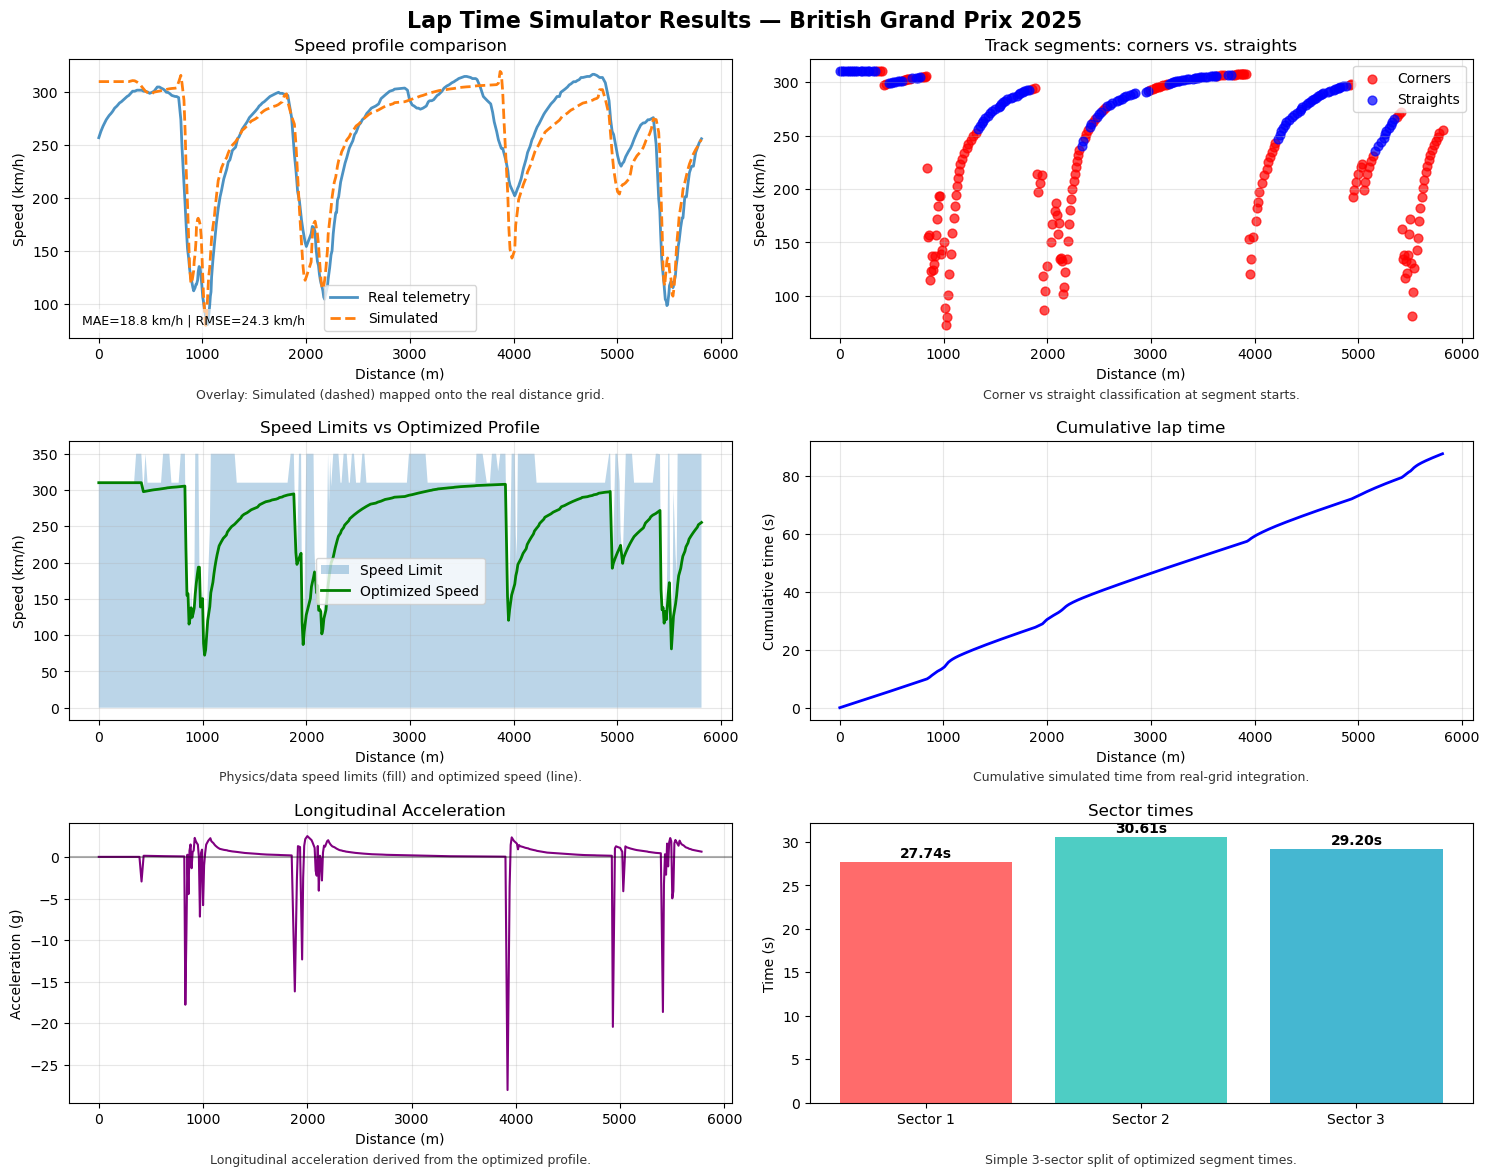


----------------------------------------
STEP 8: Track Animation & Advanced Visualization
----------------------------------------


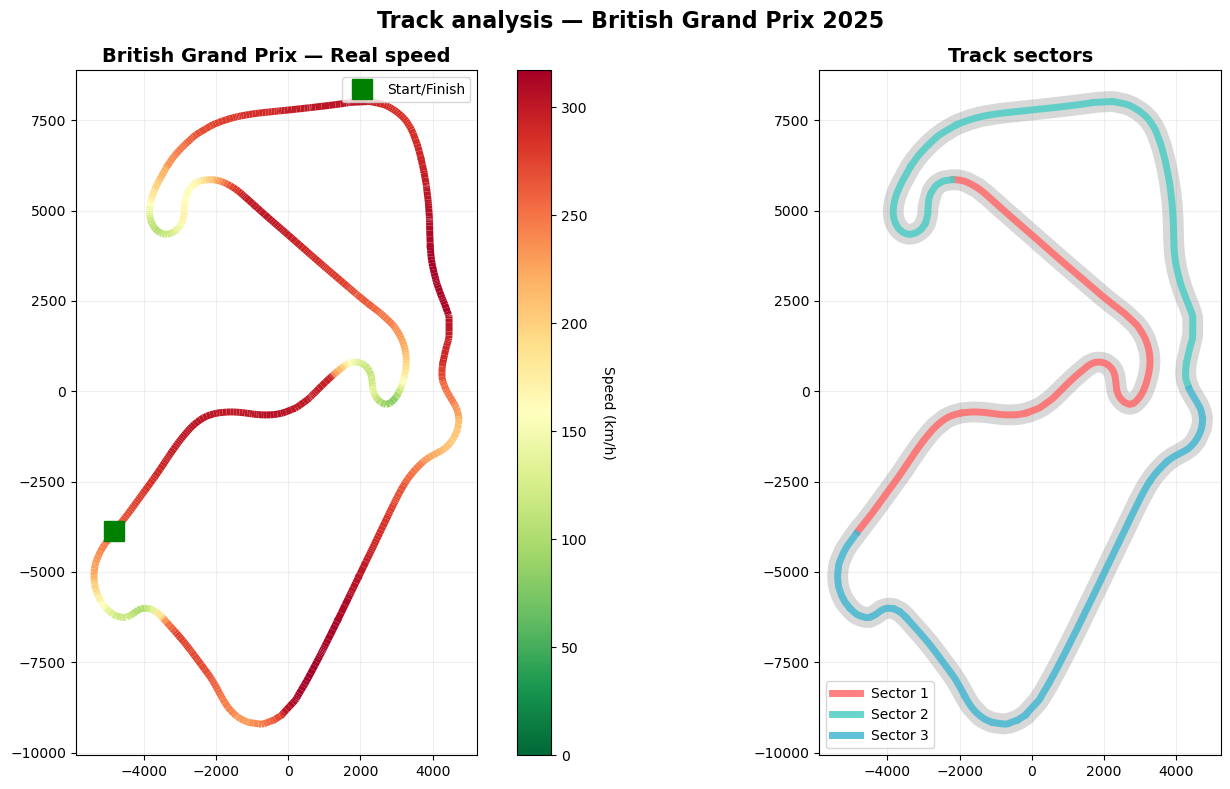

🎬 Creating animated visualization…
Saving animation to 2025_7_BritishGrandPrix_R_lap_animation.gif…
✅ Animation saved!


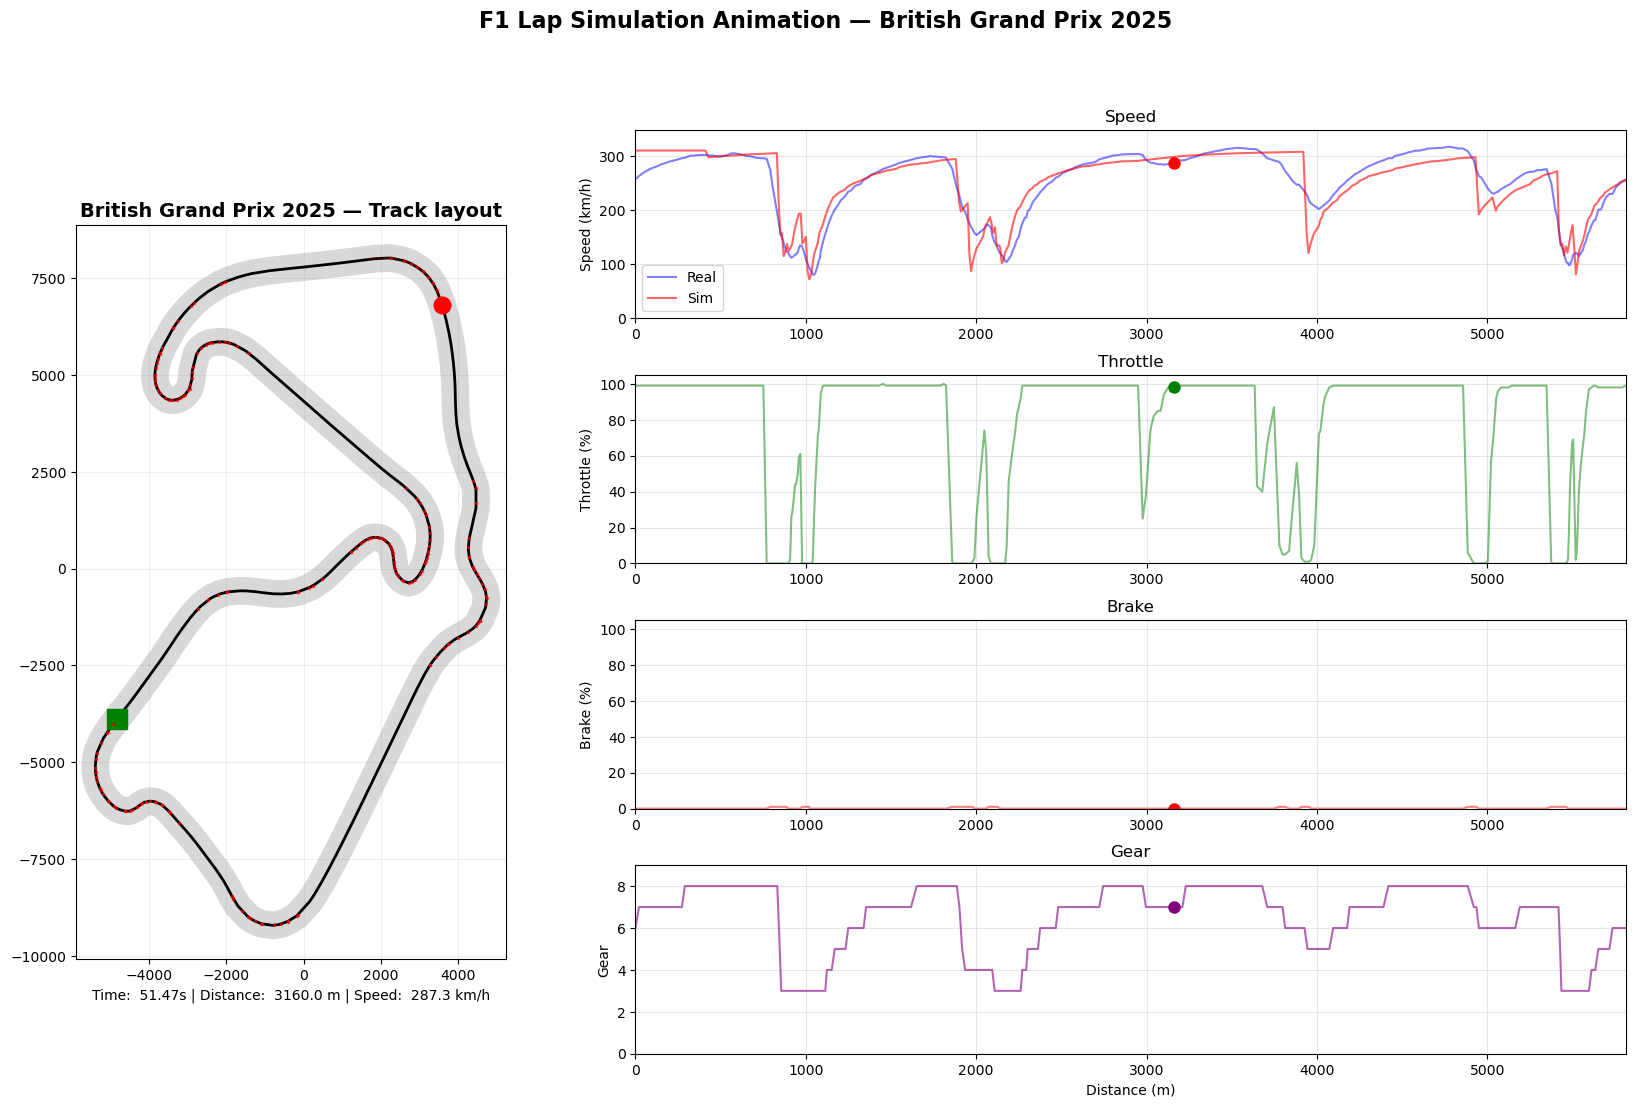

✅ Animation created!

📊 SIMULATION SUMMARY
Circuit: British Grand Prix 2025
Track Length: 5812 m
Number of Segments: 316
Number of Corners: 178

LAP TIMES:
 Real: 89.337 s
 Simulated: 88.987 s
 Difference: -0.350 s
 Accuracy: 99.6%

SPEED STATISTICS (optimized):
 Average: 243.6 km/h
 Maximum: 310.1 km/h
 Minimum: 72.4 km/h


In [32]:
# ============================================================================
# STEP 8 — Track animation (time‑based motion + telemetry overlays)
# ============================================================================

class TrackAnimator:
    """
    Build an animated view of a lap:
      • left: track layout with a moving car marker and corner dots,
      • right: scrolling markers on real telemetry (speed/throttle/brake/gear).

    Motion is time‑based: we precompute a time→distance map from the
    optimized speed profile and sample XY/telemetry at the current distance.
    """

    def __init__(self, circuit, optimized_segments: pd.DataFrame, telemetry: pd.DataFrame):
        self.circuit = circuit # titles/meta and get_track_coordinates()
        self.segments = optimized_segments.sort_values("start").reset_index(drop=True) # sorted by start distance (for monotonic sampling).
        self.telemetry = telemetry.sort_values("Distance").reset_index(drop=True) # sorted by Distance; needed for interpolation.

        # --- Animation parameters (set BEFORE use) ---
        '''
        Render 30 frames per second.
        Default max duration 15s (we’ll shorten if lap is shorter in sim time).
        '''
        self.fps = 30
        self.duration = 15  # seconds cap; will be reduced if lap < 15 s

        # Track layout & interpolation set-up
        self.track_x, self.track_y = circuit.get_track_coordinates()
        self._setup_interpolation()
        '''
        Get track XY polyline (from telemetry or circular fallback).
        Build interpolation functions for XY and telemetry channels.
        '''

        # Precompute time→distance lookup from optimized profile
        self._build_time_distance_lookup()
        '''
        Compute arrays of cumulative time and cumulative distance 
        from the optimized speed profile (used to map time → distance during animation).
        '''

        # Optionally shrink the animation length to the simulated lap time
        if np.isfinite(self.total_time) and self.total_time > 0:
            self.duration = min(self.duration, int(np.ceil(self.total_time)))
        # If the simulated lap is shorter than 10 s (e.g., a test cut), reduce duration so playback ends at lap end.
        # Number of frames
        self.frames = int(self.fps * self.duration) # Total frames = fps × duration.

    # ------------------------------- helpers ---------------------------------

    def _build_time_distance_lookup(self) -> None:
        """Precompute cumulative time and distance from the optimized speed profile."""
        dL = self.segments["length"].to_numpy(float)  # array of segment lengths in meters.
        v  = np.clip(self.segments["optimized_speed"].to_numpy(float)/3.6, 1e-2, None)  # Optimized speed per segment in m/s, with a small lower bound (avoid divide by zero).

        # Trapezoidal average speed between segments
        v_next = np.r_[v[1:], v[-1]]
        v_avg  = np.clip(0.5 * (v + v_next), 1e-2, None)                         # m/s
        '''
        Compute an average speed per segment as the 
        mean of current and next (simple trapezoidal approach).
        '''
        seg_time = dL / v_avg # s. # Per-segment time = length / average speed.

        self.cum_t = np.r_[0.0, np.cumsum(seg_time)]
        self.cum_s = np.r_[0.0, np.cumsum(dL)]
        self.total_time = float(self.cum_t[-1])
        # Build cumulative time and cumulative distance arrays (start at 0). Save total simulated lap time.

    # Monotonic guard for the Distance array (handles small jitter):
    def _setup_interpolation_arrays(self, distances: np.ndarray) -> np.ndarray:
        """Ensure Distance is non‑decreasing and unique for interpolation."""
        d = np.asarray(distances, float)
        d = np.maximum.accumulate(d)                         # enforce non‑decreasing
        d_unique, idx = np.unique(d, return_index=True)      # remove duplicates for interp. # Some sessions can have repeated Distance values; remove duplicates to make interpolation safe.
        # Align track arrays to the unique indices (if provided as same length)
        if len(self.track_x) == len(d) and len(self.track_y) == len(d):
            self.track_x = np.asarray(self.track_x, float)[idx]
            self.track_y = np.asarray(self.track_y, float)[idx]
        '''
        If track XY was sampled one-to-one with the same length as distances, sync XY with the unique-indexed Distance.
        '''
        return d_unique # Return the cleaned distance array.

    def _setup_interpolation(self) -> None:
        """Create interpolation functions for XY and real/sim telemetry vs distance."""
        # Real telemetry distance grid
        distances = self.telemetry["Distance"].to_numpy(float) 
        distances = self._setup_interpolation_arrays(distances) # Get real Distance samples and sanitize them (monotonic, unique).

        # Normalize track layout for nicer framing
        # Center the track around (0,0) so it’s visually centered in the plot.
        self.track_x = self.track_x - np.mean(self.track_x)
        self.track_y = self.track_y - np.mean(self.track_y)

        # XY vs distance (track layout)
        # Interpolators to get track XY at any distance along the lap:
        self.x_interp = interpolate.interp1d(
            distances, self.track_x, kind="cubic", bounds_error=False, fill_value="extrapolate"
        )
        self.y_interp = interpolate.interp1d(
            distances, self.track_y, kind="cubic", bounds_error=False, fill_value="extrapolate"
        )

        # Telemetry channels vs distance (real)
        # It returns an interpolation function for a telemetry column if it exists; otherwise a constant fallback:
        def _interp_col(col, kind="linear", default=None):
            if col in self.telemetry.columns:
                return interpolate.interp1d(
                    distances, self.telemetry[col].to_numpy(float),
                    kind=kind, bounds_error=False, fill_value="extrapolate"
                )
            return (lambda x, d=default: d) if default is not None else (lambda x: 0.0)

        # Build interpolators for Speed, Gear (nearest), Throttle, and Brake (linears).
        self.speed_interp    = _interp_col("Speed", kind="linear", default=0.0)
        self.gear_interp     = _interp_col("nGear", kind="nearest", default=4.0)
        self.throttle_interp = _interp_col("Throttle", kind="linear", default=50.0)
        self.brake_interp    = _interp_col("Brake", kind="linear", default=0.0)

        # Simulated speed vs distance (built from segment start points)
        # Interpolator for simulated speed as a function of distance (from the segmented result).
        sim_d = self.segments["start"].to_numpy(float)
        sim_v = self.segments["optimized_speed"].to_numpy(float)
        order = np.argsort(sim_d)
        sim_d = np.unique(sim_d[order])                     # ensure monotonic/unique x
        sim_v = sim_v[order][: len(sim_d)]
        self.sim_speed_interp = interpolate.interp1d(
            sim_d, sim_v, kind="linear", bounds_error=False, fill_value="extrapolate"
        )

    # ------------------------------- animation --------------------------------

    def create_animation(self, save_path: str | None = None):
        """Create the animated figure and return (fig, anim). Optionally save to GIF/MP4."""
        # Canvas
        fig = plt.figure(figsize=(20, 12))
        gs = GridSpec(4, 3, figure=fig, hspace=0.3, wspace=0.3)

        # Axes
        ax_track   = fig.add_subplot(gs[:, 0])   # track layout (big)
        ax_speed   = fig.add_subplot(gs[0, 1:])  # speed
        ax_throttle= fig.add_subplot(gs[1, 1:])  # throttle
        ax_brake   = fig.add_subplot(gs[2, 1:])  # brake
        ax_gear    = fig.add_subplot(gs[3, 1:])  # gear

        # Track drawing
        ax_track.plot(self.track_x, self.track_y, color="gray", linewidth=20, alpha=0.3)
        ax_track.plot(self.track_x, self.track_y, color="black", linewidth=2)
        ax_track.set_aspect("equal")
        ax_track.set_title(f"{self.circuit.gp_name} {self.circuit.year} — Track layout", fontsize=14, fontweight="bold")
        ax_track.grid(True, alpha=0.2)
        ax_track.plot(self.track_x[0], self.track_y[0], "gs", markersize=15, label="Start/Finish")

        # Corner markers
        corners = self.segments[self.segments["is_corner"]]
        for _, corner in corners.iterrows():
            x_c = self.x_interp(float(corner["start"]))
            y_c = self.y_interp(float(corner["start"]))
            ax_track.plot(x_c, y_c, "r.", markersize=3, alpha=0.6)

        # Car marker and trail
        car_marker, = ax_track.plot([], [], "ro", markersize=12, label="Car")
        car_trail,  = ax_track.plot([], [], "r-", linewidth=1, alpha=0.3)
        trail_x, trail_y = [], []
        max_trail = 50

        # Right‑side telemetry plots
        d_real = self.telemetry["Distance"].to_numpy(float)
        max_dist = float(d_real[-1])

        # Speed: plot real and sim (note: different x grids, fine for context)
        ax_speed.plot(d_real, self.telemetry["Speed"].to_numpy(float), "b-", alpha=0.5, label="Real")
        ax_speed.plot(self.segments["start"].to_numpy(float), self.segments["optimized_speed"].to_numpy(float),
                      "r-", alpha=0.6, label="Sim")
        speed_line, = ax_speed.plot([], [], "ro", markersize=8)
        ax_speed.set_xlim(0.0, max_dist)
        ax_speed.set_ylim(0.0, float(self.telemetry["Speed"].max()) * 1.1)
        ax_speed.set_ylabel("Speed (km/h)")
        ax_speed.set_title("Speed")
        ax_speed.grid(True, alpha=0.3); ax_speed.legend()

        # Throttle
        if "Throttle" in self.telemetry.columns:
            ax_throttle.plot(d_real, self.telemetry["Throttle"].to_numpy(float), "g-", alpha=0.5)
        throttle_line, = ax_throttle.plot([], [], "go", markersize=8)
        ax_throttle.set_xlim(0.0, max_dist); ax_throttle.set_ylim(0.0, 105.0)
        ax_throttle.set_ylabel("Throttle (%)"); ax_throttle.set_title("Throttle")
        ax_throttle.grid(True, alpha=0.3)

        # Brake
        if "Brake" in self.telemetry.columns:
            ax_brake.plot(d_real, self.telemetry["Brake"].to_numpy(float), "r-", alpha=0.5)
        brake_line, = ax_brake.plot([], [], "ro", markersize=8)
        ax_brake.set_xlim(0.0, max_dist); ax_brake.set_ylim(0.0, 105.0)
        ax_brake.set_ylabel("Brake (%)"); ax_brake.set_title("Brake")
        ax_brake.grid(True, alpha=0.3)

        # Gear
        if "nGear" in self.telemetry.columns:
            ax_gear.plot(d_real, self.telemetry["nGear"].to_numpy(float), color="purple", alpha=0.6)
        gear_line, = ax_gear.plot([], [], "o", color="purple", markersize=8)
        ax_gear.set_xlim(0.0, max_dist); ax_gear.set_ylim(0.0, 9.0)
        ax_gear.set_xlabel("Distance (m)"); ax_gear.set_ylabel("Gear"); ax_gear.set_title("Gear")
        ax_gear.grid(True, alpha=0.3)

        fig.suptitle(f"F1 Lap Simulation Animation — {self.circuit.gp_name} {self.circuit.year}",
                     fontsize=16, fontweight="bold")

        # Init/animate functions ------------------------------------------------
        def init():
            car_marker.set_data([], []); car_trail.set_data([], [])
            speed_line.set_data([], []); throttle_line.set_data([], [])
            brake_line.set_data([], []); gear_line.set_data([], [])
            return car_marker, car_trail, speed_line, throttle_line, brake_line, gear_line

        def animate(frame: int):
            # time‑based progress within [0, total_time]
            progress = frame / max(self.frames - 1, 1)
            t_now = progress * self.total_time if self.total_time > 0 else 0.0
            s_now = float(np.interp(t_now, self.cum_t, self.cum_s))

            # XY position & trail
            x_now = float(self.x_interp(s_now)); y_now = float(self.y_interp(s_now))
            car_marker.set_data([x_now], [y_now])
            trail_x.append(x_now); trail_y.append(y_now)
            if len(trail_x) > max_trail:
                trail_x.pop(0); trail_y.pop(0)
            car_trail.set_data(trail_x, trail_y)

            # Telemetry markers at current distance
            speed_now    = float(self.speed_interp(s_now))
            throttle_now = float(self.throttle_interp(s_now))
            brake_now    = float(self.brake_interp(s_now))
            gear_now     = float(self.gear_interp(s_now))

            speed_line.set_data([s_now], [speed_now])
            throttle_line.set_data([s_now], [throttle_now])
            brake_line.set_data([s_now], [brake_now])
            gear_line.set_data([s_now], [gear_now])

            # Status footer
            ax_track.set_xlabel(
                f"Time: {t_now:6.2f}s | Distance: {s_now:7.1f} m | Speed: {speed_now:6.1f} km/h"
            )
            return car_marker, car_trail, speed_line, throttle_line, brake_line, gear_line

        # Build animation
        anim = animation.FuncAnimation(
            fig, animate, init_func=init, frames=self.frames, interval=1000 / self.fps,
            blit=True, repeat=True
        )

        # Optional save
        if save_path:
            print(f"Saving animation to {save_path}…")
            if save_path.lower().endswith(".gif"):
                anim.save(save_path, writer="pillow", fps=self.fps)
            elif save_path.lower().endswith(".mp4"):
                anim.save(save_path, writer="ffmpeg", fps=self.fps)
            print("✅ Animation saved!")

        return fig, anim

    # ------------------------------ static view -------------------------------

    def create_static_track_view(self, source: str = "real", n_points: int = 800) -> plt.Figure:
        """
        Static two‑panel figure:
          left  — speed heat map along the track ('real' | 'sim' | 'delta' = sim − real),
          right — sector coloring of the track path (simple 3‑way split).

        Parameters
        ----------
        source : {'real','sim','delta'}
            Which speed to visualize. 'delta' emphasizes where the model over/undershoots.
        n_points : int
            Number of points for sampling along the distance axis.
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

        # Distance grid limited to the overlap between real and sim coverage
        s_max = float(min(self.telemetry["Distance"].max(), self.segments["end"].max()))
        distances = np.linspace(0.0, s_max, int(n_points))

        x_points = self.x_interp(distances)
        y_points = self.y_interp(distances)

        # Choose speed source
        if source == "sim":
            speeds = self.sim_speed_interp(distances)
            cmap, title_left, vmin, vmax = "RdYlGn_r", f"{self.circuit.gp_name} — Simulated speed", 0.0, None
        elif source == "delta":
            speeds = self.sim_speed_interp(distances) - self.speed_interp(distances)
            cmap, title_left = "coolwarm", f"{self.circuit.gp_name} — Simulated − Real"
            vmax = max(5.0, np.nanpercentile(np.abs(speeds), 99))
            vmin = -vmax
        else:
            speeds = self.speed_interp(distances)
            cmap, title_left, vmin, vmax = "RdYlGn_r", f"{self.circuit.gp_name} — Real speed", 0.0, None

        if vmax is None:
            vmax = max(float(np.nanmax(speeds)), float(np.nanpercentile(speeds, 99)))
        from matplotlib.collections import LineCollection
        pts = np.array([x_points, y_points]).T.reshape(-1, 1, 2)
        segs = np.concatenate([pts[:-1], pts[1:]], axis=1)
        lc = LineCollection(segs, cmap=cmap, linewidth=5)
        lc.set_array(speeds); lc.set_clim(vmin=vmin, vmax=vmax)
        line = ax1.add_collection(lc)
        ax1.autoscale(); ax1.set_aspect("equal"); ax1.grid(True, alpha=0.2)
        ax1.set_title(title_left, fontsize=14, fontweight="bold")
        cbar = plt.colorbar(line, ax=ax1); cbar.set_label("Speed (km/h)", rotation=270, labelpad=20)
        ax1.plot(x_points[0], y_points[0], "gs", markersize=15, label="Start/Finish")
        ax1.legend()

        # Right panel — simple 3‑sector coloring
        ax2.set_aspect("equal")
        ax2.plot(self.track_x, self.track_y, "gray", linewidth=15, alpha=0.3)
        n = len(distances)
        thirds = [0, n // 3, 2 * (n // 3), n]
        colors = ["#FF6B6B", "#4ECDC4", "#45B7D1"]; labels = ["Sector 1", "Sector 2", "Sector 3"]
        for i in range(3):
            ax2.plot(x_points[thirds[i]:thirds[i+1]], y_points[thirds[i]:thirds[i+1]],
                     color=colors[i], linewidth=5, label=labels[i], alpha=0.85)
        ax2.set_title("Track sectors", fontsize=14, fontweight="bold")
        ax2.grid(True, alpha=0.2); ax2.legend()

        plt.suptitle(f"Track analysis — {self.circuit.gp_name} {self.circuit.year}",
                     fontsize=16, fontweight="bold")
        plt.tight_layout()
        return fig

# ============================================================================
# Summary & run pipeline
# ============================================================================

def print_summary(circuit, optimized_segments: pd.DataFrame, simulated_lap_time: float, session_type: str) -> None:
    """
    Print a compact simulation summary.

    Shows: circuit info, lap times and delta/accuracy, and simple speed stats
    from the optimized profile.
    """
    real_t = float(circuit.circuit_info["lap_time"])
    sim_t  = float(simulated_lap_time)
    delta  = sim_t - real_t
    acc    = 100.0 * (1.0 - abs(delta) / max(real_t, 1e-9))

    print("\n" + "=" * 60)
    print("📊 SIMULATION SUMMARY")
    print("=" * 60)
    print(f"Circuit: {circuit.gp_name} {circuit.year}")
    print(f"Track Length: {circuit.circuit_info['track_length']:.0f} m")
    print(f"Number of Segments: {len(optimized_segments)}")
    print(f"Number of Corners: {int(optimized_segments['is_corner'].sum())}")

    print("\nLAP TIMES:")
    print(f" Real: {real_t:.3f} s")
    print(f" Simulated: {sim_t:.3f} s")
    print(f" Difference: {delta:+.3f} s")
    print(f" Accuracy: {acc:.1f}%")
    collector.Nahid2_Sim[f"{circuit.gp_name} {circuit.year} {session_type}"] = [f" Real: {real_t:.3f} s", f" Simulated: {sim_t:.3f} s", f" Difference: {delta:+.3f} s", f"Accuracy: {acc:.1f}%"]
    print("\nSPEED STATISTICS (optimized):")
    print(f" Average: {optimized_segments['optimized_speed'].mean():.1f} km/h")
    print(f" Maximum: {optimized_segments['optimized_speed'].max():.1f} km/h")
    print(f" Minimum: {optimized_segments['optimized_speed'].min():.1f} km/h")
    print("=" * 60)


def _add_captions_under_axes(fig: plt.Figure, captions: list[str], y_offset: float = -0.18, fontsize: int = 9) -> None:
    """
    Add a short caption under each axes in a figure. Uses Axes coords (0..1).
    """
    for ax, cap in zip(fig.axes, captions):
        ax.text(0.5, y_offset, cap, transform=ax.transAxes,
                ha="center", va="top", fontsize=fontsize, alpha=0.8)
    fig.tight_layout()


# ------------------------------ configuration ------------------------------

year = 2025
round_no = 7                                    # avoid shadowing built-in round()
gp_name = 'British Grand Prix'
session_type = "R"

segment_length = 10                              # Monaco often benefits from 6–8 m; keep 10 if preferred
create_animation = True
save_animation = True

animation_path = f"{year}_{round_no}_{gp_name.replace(' ', '')}_{session_type}_lap_animation.gif"

# ------------------------------ STEP 1–2: load ------------------------------

print("\n" + "-" * 40)
print("STEP 1–2: Loading Circuit Data")
print("-" * 40)
circuit = CircuitData(year, gp_name, session_type)
circuit.load_session()
telemetry = circuit.get_fastest_lap_telemetry()
corners = circuit.identify_corners()

print("\n📊 Circuit Statistics:")
print(f" Track Length: {circuit.circuit_info['track_length']:.0f} meters")
print(f" Fastest Lap: {circuit.circuit_info['lap_time']:.3f} seconds")
print(f" Driver: {circuit.circuit_info['driver']}")
print(f" Max Speed: {circuit.circuit_info['max_speed']:.1f} km/h")
print(f" Corners identified (quick heuristic): {len(corners)}")

# ------------------------------ STEP 3: vehicle -----------------------------

print("\n" + "-" * 40)
print("STEP 3: Vehicle Model")
print("-" * 40)
vehicle = VehicleModel()
vehicle.top_gear_total_ratio = 4.6  # a reasonable value

vehicle.rho = circuit.circuit_info.get("air_density", 1.225)
retarget_CdA_for_top_speed(vehicle, target_kmh = telemetry['Speed'].max(), drs=True)

print("🏎️ Vehicle Performance Characteristics:")
print(f" Max corner speed (R=50 m):  {vehicle.max_corner_speed(50):.1f} km/h")
print(f" Max corner speed (R=100 m): {vehicle.max_corner_speed(100):.1f} km/h")

# ------------------------------ STEP 4: segments ----------------------------

print("\n" + "-" * 40)
print("STEP 4: Track Discretization")
print("-" * 40)
track = TrackDiscretization(telemetry, segment_length=segment_length)
segments_df = track.create_segments() 
print("📍 Track Discretization Complete:")
print(f" Total segments:  {len(segments_df)}")
print(f" Corner segments: {int(segments_df['is_corner'].sum())}")

# # --- NEW: show sample counts ---
# print(f" Avg samples/seg:  {segments_df['sample_count'].mean():.1f}")
# print(f" Min samples/seg:  {segments_df['sample_count'].min()}")
# print(f" Max samples/seg:  {segments_df['sample_count'].max()}")

# # Optional: If we want to see the first few rows
# print("\nFirst few segments with sample counts:")
# print(segments_df[['id','start','end','sample_count','is_corner']].head())

# ------------------------------ STEP 5: limits ------------------------------

print("\n" + "-" * 40)
print("STEP 5: Physics-Only Performance Limits")
print("-" * 40)

# Pure physics speed envelope (no telemetry caps)
perf_limits = PhysicsLimits(vehicle, segments_df)
segments_with_limits = perf_limits.calculate_speed_limits()

# ------------------------------ STEP 6: optimize ----------------------------

print("\n" + "-" * 40)
print("STEP 6: Lap Time Optimization")
print("-" * 40)
optimizer = LapTimeOptimizer(vehicle, segments_with_limits)
optimized_segments = optimizer.optimize()

# Integrate time on the real distance grid for the reported simulated lap time
_, _, cum_time = sim_time_from_real_grid(optimized_segments, telemetry)
simulated_lap_time = float(cum_time[-1])

# Optional: account for upshift time loss
shift_pen = estimate_shift_penalty(optimized_segments)
simulated_lap_time += shift_pen
print(f"Shift penalty applied: +{shift_pen:.3f} s")


# ------------------------------ STEP 7: plots -------------------------------

print("\n" + "-" * 40)
print("STEP 7: Basic Visualization")
print("-" * 40)
fig = create_visualizations(circuit, optimized_segments, telemetry)

# Add short captions under each subplot
captions = [
    "Overlay: Simulated (dashed) mapped onto the real distance grid.",
    "Corner vs straight classification at segment starts.",
    "Physics/data speed limits (fill) and optimized speed (line).",
    "Cumulative simulated time from real‑grid integration.",
    "Longitudinal acceleration derived from the optimized profile.",
    "Simple 3‑sector split of optimized segment times."
]
_add_captions_under_axes(fig, captions)
plt.show()

# ------------------------------ STEP 8: animation ---------------------------

print("\n" + "-" * 40)
print("STEP 8: Track Animation & Advanced Visualization")
print("-" * 40)
animator = TrackAnimator(circuit, optimized_segments, telemetry)

# Static track visualization (left heat-map, right sectors)
track_fig = animator.create_static_track_view(source="real")
plt.show()

if create_animation:
    print("🎬 Creating animated visualization…")
    if save_animation:
        anim_fig, anim = animator.create_animation(save_path=animation_path)
    else:
        anim_fig, anim = animator.create_animation()
    plt.show()
    print("✅ Animation created!")

# ------------------------------ final summary -------------------------------

print_summary(circuit, optimized_segments, simulated_lap_time, session_type)


In [33]:
print("\n📊 Circuit Statistics:")
print(f"Circuit: {circuit.gp_name} {circuit.year} {session_type}")
print(f" Track Length: {circuit.circuit_info['track_length']:.0f} meters")
print(f" Fastest Lap: {circuit.circuit_info['lap_time']:.3f} seconds")
print(f" Driver: {circuit.circuit_info['driver']}")
print(f" Max Speed: {circuit.circuit_info['max_speed']:.1f} km/h")
# print(f" Corners identified (quick heuristic): {len(corners)}")

real_t = float(circuit.circuit_info["lap_time"])
sim_t  = float(simulated_lap_time)
delta  = sim_t - real_t
acc    = 100.0 * (1.0 - abs(delta) / max(real_t, 1e-9))
print("\nLAP TIMES:")
print(f" Real: {real_t:.3f} s")
print(f" Simulated: {sim_t:.3f} s")
print(f" Difference: {delta:+.3f} s")
print(f" Accuracy: {acc:.1f}%")


📊 Circuit Statistics:
Circuit: British Grand Prix 2025 R
 Track Length: 5812 meters
 Fastest Lap: 89.337 seconds
 Driver: PIA
 Max Speed: 317.0 km/h

LAP TIMES:
 Real: 89.337 s
 Simulated: 88.987 s
 Difference: -0.350 s
 Accuracy: 99.6%


In [34]:
# List the schedule for a season
schedule = fastf1.get_event_schedule(2025)

# Show the event keys and their session identifiers
print(schedule[['RoundNumber', 'EventName', 'OfficialEventName', 'EventFormat']])


    RoundNumber                  EventName  \
0             0         Pre-Season Testing   
1             1      Australian Grand Prix   
2             2         Chinese Grand Prix   
3             3        Japanese Grand Prix   
4             4         Bahrain Grand Prix   
5             5   Saudi Arabian Grand Prix   
6             6           Miami Grand Prix   
7             7  Emilia Romagna Grand Prix   
8             8          Monaco Grand Prix   
9             9         Spanish Grand Prix   
10           10        Canadian Grand Prix   
11           11        Austrian Grand Prix   
12           12         British Grand Prix   
13           13         Belgian Grand Prix   
14           14       Hungarian Grand Prix   
15           15           Dutch Grand Prix   
16           16         Italian Grand Prix   
17           17      Azerbaijan Grand Prix   
18           18       Singapore Grand Prix   
19           19   United States Grand Prix   
20           20     Mexico City Gr

In [35]:
# dict_of_Raul_sim = {'Australian Grand Prix 2025 R': [' Real: 82.167 s', ' Simulated: 70.163 s', ' Difference: -12.004 s', 'Accuracy: 85.4%'], 'Chinese Grand Prix 2025 R': [' Real: 95.069 s', ' Simulated: 93.882 s', ' Difference: -1.187 s', 'Accuracy: 98.8%'], 'Japanese Grand Prix 2025 R': [' Real: 90.965 s', ' Simulated: 80.227 s', ' Difference: -10.738 s', 'Accuracy: 88.2%'], 'Bahrain Grand Prix 2025 R': [' Real: 95.140 s', ' Simulated: 94.546 s', ' Difference: -0.594 s', 'Accuracy: 99.4%'], 'Saudi Arabian Grand Prix 2025 R': [' Real: 91.778 s', ' Simulated: 80.548 s', ' Difference: -11.230 s', 'Accuracy: 87.8%'], 'Miami Grand Prix 2025 R': [' Real: 89.746 s', ' Simulated: 87.710 s', ' Difference: -2.036 s', 'Accuracy: 97.7%'], 'Emilia Romagna Grand Prix 2025 R': [' Real: 77.988 s', ' Simulated: 69.835 s', ' Difference: -8.153 s', 'Accuracy: 89.5%'], 'Monaco Grand Prix 2025 R': [' Real: 73.221 s', ' Simulated: 79.877 s', ' Difference: +6.656 s', 'Accuracy: 90.9%'], 'Spanish Grand Prix 2025 R': [' Real: 75.743 s', ' Simulated: 69.563 s', ' Difference: -6.180 s', 'Accuracy: 91.8%'], 'Canadian Grand Prix 2025 R': [' Real: 74.119 s', ' Simulated: 72.170 s', ' Difference: -1.949 s', 'Accuracy: 97.4%'], 'Austrian Grand Prix 2025 R': [' Real: 67.924 s', ' Simulated: 60.034 s', ' Difference: -7.890 s', 'Accuracy: 88.4%'], 'British Grand Prix 2025 R': [' Real: 89.337 s', ' Simulated: 80.322 s', ' Difference: -9.015 s', 'Accuracy: 89.9%'], 'Belgian Grand Prix 2025 R': [' Real: 104.861 s', ' Simulated: 94.127 s', ' Difference: -10.734 s', 'Accuracy: 89.8%'], 'Hungarian Grand Prix 2025 R': [' Real: 79.409 s', ' Simulated: 77.917 s', ' Difference: -1.492 s', 'Accuracy: 98.1%'], 'Dutch Grand Prix 2025 R': [' Real: 72.271 s', ' Simulated: 68.057 s', ' Difference: -4.214 s', 'Accuracy: 94.2%'], 'Italian Grand Prix 2025 FP1': [' Real: 80.117 s', ' Simulated: 70.102 s', ' Difference: -10.015 s', 'Accuracy: 87.5%'], 'Italian Grand Prix 2025 FP2': [' Real: 79.878 s', ' Simulated: 73.917 s', ' Difference: -5.961 s', 'Accuracy: 92.5%']}

# dict_of_Nahid2_sim = {'Australian Grand Prix 2025 R': [' Real: 82.167 s', ' Simulated: 85.162 s', ' Difference: +2.995 s', 'Accuracy: 96.4%'], 'Chinese Grand Prix 2025 R': [' Real: 95.069 s', ' Simulated: 95.038 s', ' Difference: -0.031 s', 'Accuracy: 100.0%'], 'Japanese Grand Prix 2025 R': [' Real: 90.965 s', ' Simulated: 91.102 s', ' Difference: +0.137 s', 'Accuracy: 99.8%'], 'Bahrain Grand Prix 2025 R': [' Real: 95.140 s', ' Simulated: 86.294 s', ' Difference: -8.846 s', 'Accuracy: 90.7%'], 'Saudi Arabian Grand Prix 2025 R': [' Real: 91.778 s', ' Simulated: 94.529 s', ' Difference: +2.751 s', 'Accuracy: 97.0%'], 'Miami Grand Prix 2025 R': [' Real: 89.746 s', ' Simulated: 88.349 s', ' Difference: -1.397 s', 'Accuracy: 98.4%'], 'Emilia Romagna Grand Prix 2025 R': [' Real: 77.988 s', ' Simulated: 79.150 s', ' Difference: +1.162 s', 'Accuracy: 98.5%'], 'Monaco Grand Prix 2025 R': [' Real: 73.221 s', ' Simulated: 67.560 s', ' Difference: -5.661 s', 'Accuracy: 92.3%'], 'Spanish Grand Prix 2025 R': [' Real: 75.743 s', ' Simulated: 75.829 s', ' Difference: +0.086 s', 'Accuracy: 99.9%'], 'Canadian Grand Prix 2025 R': [' Real: 74.119 s', ' Simulated: 69.586 s', ' Difference: -4.533 s', 'Accuracy: 93.9%'], 'Austrian Grand Prix 2025 R': [' Real: 67.924 s', ' Simulated: 66.605 s', ' Difference: -1.319 s', 'Accuracy: 98.1%'], 'British Grand Prix 2025 R': [' Real: 89.337 s', ' Simulated: 88.987 s', ' Difference: -0.350 s', 'Accuracy: 99.6%'], 'Belgian Grand Prix 2025 R': [' Real: 104.861 s', ' Simulated: 104.149 s', ' Difference: -0.712 s', 'Accuracy: 99.3%'], 'Hungarian Grand Prix 2025 R': [' Real: 79.409 s', ' Simulated: 76.925 s', ' Difference: -2.484 s', 'Accuracy: 96.9%'], 'Dutch Grand Prix 2025 R': [' Real: 72.271 s', ' Simulated: 74.045 s', ' Difference: +1.774 s', 'Accuracy: 97.5%'], 'Italian Grand Prix 2025 FP1': [' Real: 80.117 s', ' Simulated: 79.924 s', ' Difference: -0.193 s', 'Accuracy: 99.8%'], 'Italian Grand Prix 2025 FP2': [' Real: 79.878 s', ' Simulated: 79.971 s', ' Difference: +0.093 s', 'Accuracy: 99.9%']}